In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from time import time

In [2]:
from pandas import ewma, DataFrame, Series

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim

In [5]:
torch.__version__

'0.4.0'

In [6]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [7]:
torch.cuda.set_device(6)

In [8]:
device = torch.device('cuda' if USE_CUDA else 'cpu')

In [9]:
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

In [11]:
batch_size = 100
original_width, original_height = 28, 28
width, height = 48, 48

In [12]:
kwargs = {'num_workers': 0, 'pin_memory': True} if USE_CUDA else {}

dataset = MNIST

train_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=True, download=True, transform=transforms.Compose([
            transforms.RandomChoice(
                [transforms.Pad((i, 0, width-original_width-i, 0)) for i in range(width-original_width+1)]
            ),
            transforms.RandomChoice(
                [transforms.Pad((0, i, 0, height-original_height-i)) for i in range(height-original_height+1)]
            ),
            transforms.ToTensor()
        ])
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

test_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=False, download=True, transform=transforms.Compose([
            transforms.RandomChoice(
                [transforms.Pad((i, 0, width-original_width-i, 0)) for i in range(width-original_width+1)]
            ),
            transforms.RandomChoice(
                [transforms.Pad((0, i, 0, height-original_height-i)) for i in range(height-original_height+1)]
            ),
            transforms.ToTensor()
        ])
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

In [31]:
next(iter(test_loader))[0].shape

torch.Size([100, 1, 48, 48])

In [ ]:
np.random.seed(123)

train_data = train_loader.dataset.train_data.numpy()
padded_train_data = []
for i in range(train_data.shape[0]):
    right_pad = np.random.choice(width - original_width + 1)
    bottom_pad = np.random.choice(height - original_height + 1)
    padded_train_data.append(np.pad(
        train_data[i], 
        pad_width=((width-original_width-right_pad, right_pad), (height-original_height-bottom_pad, bottom_pad)),
        mode='constant'
    ))
padded_train_data = np.array(padded_train_data)

In [16]:
padded_train_data_loader = torch.utils.data.DataLoader(
    TensorDataset(
        torch.from_numpy(padded_train_data).float() / 255, 
        train_loader.dataset.train_labels
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

In [20]:
print(train_loader.dataset.train_data.shape)
print(test_loader.dataset.test_data.shape)
print(padded_train_data_loader.dataset.tensors[0].shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
torch.Size([60000, 48, 48])


In [21]:
np.sum(np.array(train_loader.dataset.train_labels) == 0) / np.array(train_loader.dataset.train_labels).shape[0]

0.098716666666666661

In [23]:
input_shape = [1, height, width]
output_size = 10

**DAE**

In [24]:
def binary_crossentropy_loss(x_true, x_distr):
    """
    Вычисляет бинарную кроссэнтропию между эмприческим распределением на данные
    и индуцированным моделью распределением, т. е. правдоподобие объектов x_true.
    Каждому объекту из x_true соответствуют K сэмплированных распределений
    на x из x_distr.
    i-му объекту соответствуют распределения с номерами i * K, ..., (i + 1) * K - 1.
    Требуется вычислить оценку логарифма правдоподобия для каждого объекта.
    Подсказка: не забывайте про вычислительную стабильность!

    Вход: x_true, Variable - матрица объектов размера n x D.
    Вход: x_distr, Variable - матрица параметров распределений Бернулли
    размера (n * K) x D.
    Выход: Variable, матрица размера n x K - оценки логарифма правдоподобия
    каждого сэмпла.
    """
    K = x_distr.shape[0] // x_true.shape[0]
    #print(x_true.shape, x_distr.shape)
    n, D = x_true.shape
    eps = 1e-5
    x_distr = torch.clamp(x_distr.view(n, K, D), eps, 1-eps)
    x_true = x_true.view(n, 1, D)
    return -torch.sum(torch.log(x_distr) * x_true + torch.log(1 - x_distr) * (1 - x_true), dim=2)

In [25]:
def kl(q_distr, p_distr):
    """
    Вычисляется KL-дивергенция KL(q || p) между n парами гауссиан.
    Вход: q_distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
    Первое - mu, второе - sigma.
    Вход: p_distr, tuple(Variable, Varable). Аналогично.
    Возвращаемое значение: Variable, вектор размерности n, каждое значение которого - 
    - KL-дивергенция между соответствующей парой распределений.
    """
    mu_q, sigma_q = q_distr
    mu_p, sigma_p = p_distr
    n, d = mu_p.shape
    return 0.5 * (
        torch.sum(
            (sigma_q ** 2 + (mu_p - mu_q) ** 2) / sigma_p ** 2 - 1 + 2 * (torch.log(sigma_p) - torch.log(sigma_q)), dim=1
        )
    )

In [26]:
class ReshapeLayer(nn.Module):
    def __init__(self, *args):
        super(ReshapeLayer, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)

In [27]:
class DAE(nn.Module):
    def __init__(self, input_shape, latent_dim, noise=0.1):

        super(type(self), self).__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.noise = noise
        
        self.proposal_network = nn.Sequential(
            ReshapeLayer(*input_shape),
            nn.Conv2d(1, 128, 4, padding=1, stride=2), # [128 x 24 x 24]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, padding=1, stride=2), # [256 x 12 x 12]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, 4, padding=1, stride=2), # [512 x 6 x 6]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, 4, padding=1, stride=2), # [1024 x 3 x 3]
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            ReshapeLayer(1024 * 3 * 3),
            nn.Linear(1024 * 3 * 3, latent_dim)
        )
        
        self.generative_network = nn.Sequential(
            nn.Linear(latent_dim, 1024 * 3 * 3),
            ReshapeLayer(1024, 3, 3), # [1024 x 3 x 3]
            nn.ConvTranspose2d(1024, 512, 4, padding=1, stride=2), # [512 x 6 x 6]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, padding=1, stride=2), # [256 x 12 x 12]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, padding=1, stride=2), # [128 x 24 x 24]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, padding=1, stride=2), # [128 x 48 x 48]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 1, 1), # [1 x 48 x 48]
            nn.Sigmoid()
        )

    def batch_loss(self, X):
        n = X.shape[0]
        Z = self.proposal_network(X + torch.normal(mean=torch.zeros_like(X)) * self.noise)
        X_rec = self.generative_network(Z)
        #reconstruction_loss = torch.sum((X_rec - X) ** 2) / n
        #reconstruction_loss = torch.sum(torch.abs(X_rec - X)) / n
        reconstruction_loss = torch.sum(binary_crossentropy_loss(X.view(n, -1), X_rec.view(n, -1))) / n
        return reconstruction_loss


In [33]:
def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].view(height, width).cpu().numpy(), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

Didn't found pretrained VAE; training...
Epoch 1 of 50 took 82.50s;
train reconstruction loss: 436.38; test reconstruction loss: 154.46

Epoch 2 of 50 took 82.97s;
train reconstruction loss: 121.71; test reconstruction loss: 107.64

Epoch 3 of 50 took 82.79s;
train reconstruction loss: 95.13; test reconstruction loss: 88.67

Epoch 4 of 50 took 83.10s;
train reconstruction loss: 85.93; test reconstruction loss: 82.06

Epoch 5 of 50 took 82.79s;
train reconstruction loss: 81.25; test reconstruction loss: 81.95



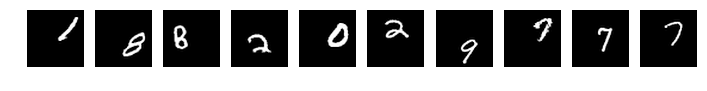

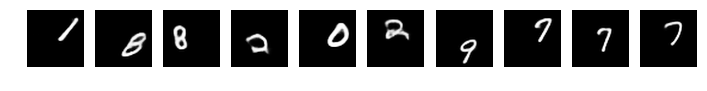

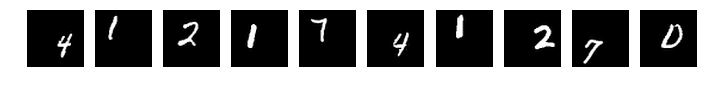

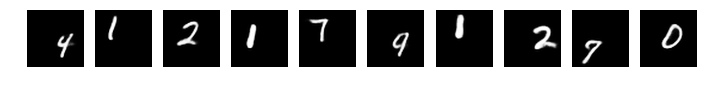

Epoch 6 of 50 took 83.11s;
train reconstruction loss: 78.14; test reconstruction loss: 78.26

Epoch 7 of 50 took 82.80s;
train reconstruction loss: 75.88; test reconstruction loss: 76.36

Epoch 8 of 50 took 82.69s;
train reconstruction loss: 74.26; test reconstruction loss: 75.96

Epoch 9 of 50 took 83.08s;
train reconstruction loss: 72.82; test reconstruction loss: 75.11

Epoch 10 of 50 took 82.52s;
train reconstruction loss: 71.65; test reconstruction loss: 74.57



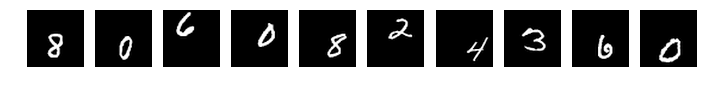

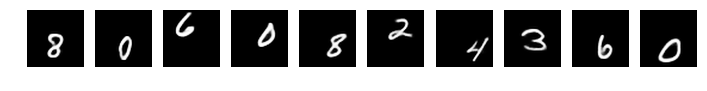

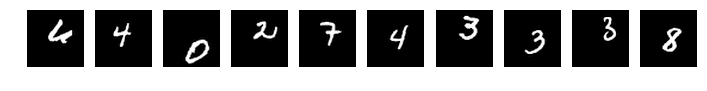

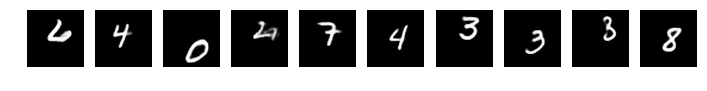

Epoch 11 of 50 took 83.08s;
train reconstruction loss: 70.61; test reconstruction loss: 72.86

Epoch 12 of 50 took 83.14s;
train reconstruction loss: 69.68; test reconstruction loss: 72.85

Epoch 13 of 50 took 83.09s;
train reconstruction loss: 68.83; test reconstruction loss: 72.32

Epoch 14 of 50 took 82.70s;
train reconstruction loss: 68.14; test reconstruction loss: 72.71

Epoch 15 of 50 took 83.15s;
train reconstruction loss: 67.48; test reconstruction loss: 71.96



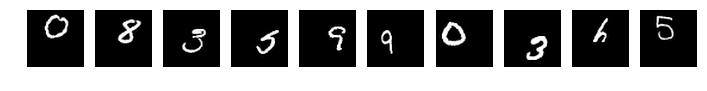

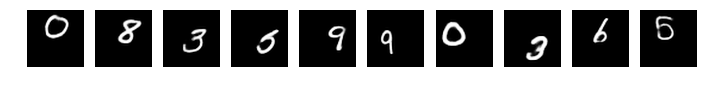

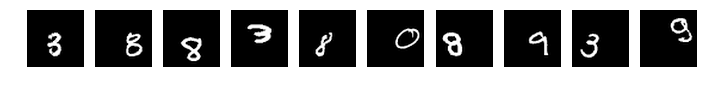

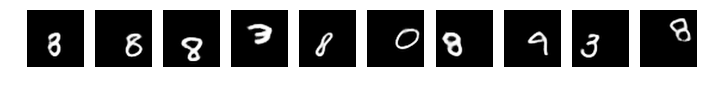

Epoch 16 of 50 took 82.43s;
train reconstruction loss: 66.79; test reconstruction loss: 71.48

Epoch 17 of 50 took 82.73s;
train reconstruction loss: 66.17; test reconstruction loss: 71.18

Epoch 18 of 50 took 83.15s;
train reconstruction loss: 65.67; test reconstruction loss: 71.49

Epoch 19 of 50 took 82.88s;
train reconstruction loss: 65.13; test reconstruction loss: 71.77

Epoch 20 of 50 took 82.84s;
train reconstruction loss: 64.75; test reconstruction loss: 71.58



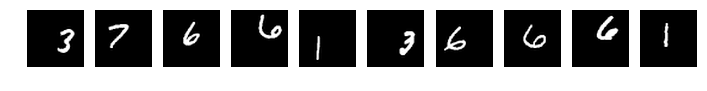

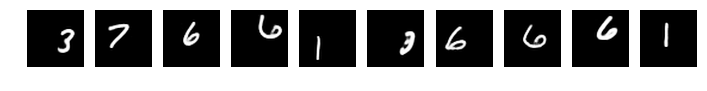

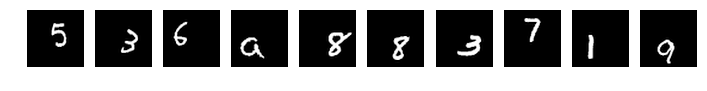

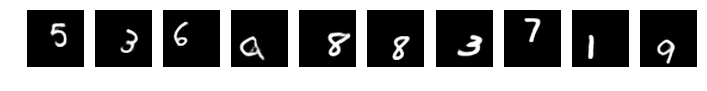

Epoch 21 of 50 took 82.60s;
train reconstruction loss: 64.22; test reconstruction loss: 71.26

Epoch 22 of 50 took 82.98s;
train reconstruction loss: 63.84; test reconstruction loss: 71.66

Epoch 23 of 50 took 82.51s;
train reconstruction loss: 63.45; test reconstruction loss: 71.63

Epoch 24 of 50 took 82.73s;
train reconstruction loss: 63.05; test reconstruction loss: 71.05

Epoch 25 of 50 took 82.56s;
train reconstruction loss: 62.74; test reconstruction loss: 72.01



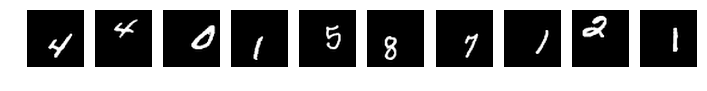

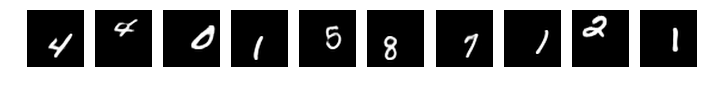

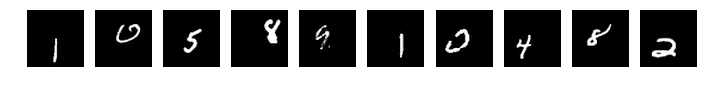

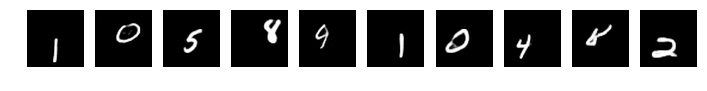

Epoch 26 of 50 took 82.73s;
train reconstruction loss: 62.37; test reconstruction loss: 72.13

Epoch 27 of 50 took 82.83s;
train reconstruction loss: 62.03; test reconstruction loss: 71.69

Epoch 28 of 50 took 83.14s;
train reconstruction loss: 61.74; test reconstruction loss: 72.21

Epoch 29 of 50 took 82.75s;
train reconstruction loss: 61.46; test reconstruction loss: 71.15



KeyboardInterrupt: 

In [35]:
latent_dim = 16

num_epochs = 50
save_every = 10

name_prefix = 'dae_results_mnist/'

#try:
if True:
#    vae = VAE(input_shape, latent_dim).to(device)
#    vae.load_state_dict(torch.load(name_prefix + 'vae.pt'))
#    print("Found pretrained VAE")
#except:
    print("Didn't found pretrained VAE; training...")
    
    dae = DAE(input_shape, latent_dim, noise=0.1).to(device)
    optimizer = optim.Adam(
        dae.parameters(), lr=3e-4, betas=(0.5, 0.999)
    )

    scheduler = optim.lr_scheduler.LambdaLR(
        optimizer, lambda n: 1 if n < 30 else 0.5 if n < 50 else 0.1 if n < 100 else 0.01
    )

    for epoch in range(num_epochs):
        start_time = time()
        
        #scheduler.step()
        
        cum_loss_reconstruction = 0
        batch_count = 0
        
        for X_batch, _ in padded_train_data_loader:
            X_batch = X_batch.to(device)

            loss_reconstruction = dae.batch_loss(X_batch)
            cum_loss_reconstruction += loss_reconstruction.item()
                
            optimizer.zero_grad()
            loss_reconstruction.backward()
            optimizer.step()
            batch_count += 1
    
        mean_train_loss_reconstruction = cum_loss_reconstruction / batch_count

        cum_loss_reconstruction = 0
        batch_count = 0
        
        with torch.no_grad():
            for X_batch, _ in test_loader:
                X_batch = X_batch.to(device)

                loss_reconstruction = dae.batch_loss(X_batch)
                cum_loss_reconstruction += loss_reconstruction.item()
        
                batch_count += 1
            
        mean_test_loss_reconstruction = cum_loss_reconstruction / batch_count

        print('Epoch {} of {} took {:.2f}s;'.format(epoch+1, num_epochs, time() - start_time))
        print('train reconstruction loss: {:.2f}; test reconstruction loss: {:.2f}'.format(
            mean_train_loss_reconstruction, mean_test_loss_reconstruction
        ))
        print()
        
        if (epoch+1) % 5 == 0:
            X_batch = next(iter(padded_train_data_loader))[0][:10].to(device)
            show_images(X_batch)
            plt.show()
            show_images(
                dae.generative_network(
                    dae.proposal_network(X_batch)
                )
            )
            plt.show()
            X_batch = next(iter(test_loader))[0][:10].to(device)
            show_images(X_batch)
            plt.show()
            show_images(
                dae.generative_network(
                    dae.proposal_network(X_batch)
                )
            )
            plt.show()
    
        #if (epoch+1) % save_every == 0:
        #    torch.save(vae.state_dict(), name_prefix + 'vae.pt')
        


In [39]:
torch.save(dae.state_dict(), 'dae_results_translated_mnist/dae.pt')


**Tangent prop**

In [36]:
def constrain_loss_function(model, generative_model, batch_gen, reparam_invariant=True, use_all_classes=False):
    latent_dim = generative_model.latent_dim
    
    if reparam_invariant:
        X_gen, _ = next(batch_gen)
        X_gen = X_gen.to(device).requires_grad_()
        z_inferred = generative_model.proposal_network(X_gen) # [batch_size x latent_dim]
    else:
        X, _ = next(batch_gen)
        X = X.to(device)
        z_inferred = generative_model.proposal_network(X).detach().requires_grad_() # [batch_size x latent_dim]
    X_inferred = generative_model.generative_network(z_inferred) # [batch_size x C x H x W]
    model_logits = model(X_inferred) # [batch_size x num_classes]
    model_output = F.softmax(model_logits, dim=-1)
    
    if use_all_classes:
        grad_output_wrt_input_for_each_class = []
        for output in torch.unbind(torch.sum(model_output, dim=0)):
            grad_output_wrt_input_for_each_class.append(
                autograd.grad([output], [X_gen if reparam_invariant else z_inferred], create_graph=True)[0]
            ) # [batch_size x latent_dim]
        grad_output_wrt_input = torch.stack(
            grad_output_wrt_input_for_each_class
        ) # [num_classes x batch_size x latent_dim]
        return torch.sum(grad_output_wrt_input ** 2) / batch_size
    else:
        y = np.random.choice(output_size)
        output = torch.sum(model_output, dim=0)[y]
        grad_output_wrt_input = autograd.grad(
            [output], [X_gen if reparam_invariant else z_inferred], create_graph=True
        )[0]
        return output_size * torch.sum(grad_output_wrt_input ** 2) / batch_size

**Training**

In [37]:
class ModelConvolutional(nn.Module):
    def __init__(
        self, input_shape, output_size 
    ):
        super(type(self), self).__init__()
        #assert input_shape[1] == input_shape[2]
        self.layers = nn.ModuleList([
            ReshapeLayer(*input_shape),
            nn.Dropout(p=0.2),
            nn.Conv2d(1, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(96),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(96, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(192),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(192, 192, 3),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.AvgPool2d(10)
        ])
        self.output_layer = nn.utils.weight_norm(nn.Linear(192, 10))
        
    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        X = X.view(X.shape[0], -1)
        return self.output_layer(X)

In [38]:
train_losses = {}
train_accs = {}

test_losses = {}
test_accs = {}

run 1
eta = 100



/home/golikov/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Epoch 1 of 1000 took 4.24s;
train loss:
data term: 2.30, constrain term: 0.00, full: 2.30
train acc: 10.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 9.58

Epoch 2 of 1000 took 4.40s;
train loss:
data term: 2.29, constrain term: 0.00, full: 2.29
train acc: 16.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 9.58

Epoch 3 of 1000 took 4.37s;
train loss:
data term: 2.29, constrain term: 0.00, full: 2.29
train acc: 24.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 9.58

Epoch 4 of 1000 took 4.23s;
train loss:
data term: 2.28, constrain term: 0.00, full: 2.28
train acc: 32.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 9.58

Epoch 5 of 1000 took 4.17s;
train loss:
data term: 2.27, constrain term: 0.00, full: 2.27
train acc: 30.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 9.58

Epoch 6 of 1000 took 4.23s;
train loss:
data term: 2.26, constrain term: 0.00, full: 2.26
train acc: 32.00
test loss:
data term: 2.30, const

Epoch 49 of 1000 took 4.27s;
train loss:
data term: 1.98, constrain term: 0.00, full: 1.98
train acc: 44.00
test loss:
data term: 2.12, constrain term: 0.00
test acc: 19.55

Epoch 50 of 1000 took 4.30s;
train loss:
data term: 1.97, constrain term: 0.00, full: 1.97
train acc: 50.00
test loss:
data term: 2.11, constrain term: 0.00
test acc: 19.95

Epoch 51 of 1000 took 4.26s;
train loss:
data term: 1.96, constrain term: 0.00, full: 1.99
train acc: 48.00
test loss:
data term: 2.11, constrain term: 0.00
test acc: 20.23

Epoch 52 of 1000 took 4.36s;
train loss:
data term: 1.95, constrain term: 0.00, full: 1.96
train acc: 46.00
test loss:
data term: 2.10, constrain term: 0.00
test acc: 20.66

Epoch 53 of 1000 took 4.37s;
train loss:
data term: 1.94, constrain term: 0.00, full: 1.94
train acc: 44.00
test loss:
data term: 2.09, constrain term: 0.00
test acc: 21.34

Epoch 54 of 1000 took 4.26s;
train loss:
data term: 1.94, constrain term: 0.00, full: 1.94
train acc: 48.00
test loss:
data term: 

Epoch 97 of 1000 took 4.27s;
train loss:
data term: 1.54, constrain term: 0.00, full: 1.60
train acc: 72.00
test loss:
data term: 1.87, constrain term: 0.00
test acc: 40.85

Epoch 98 of 1000 took 4.30s;
train loss:
data term: 1.52, constrain term: 0.00, full: 1.53
train acc: 76.00
test loss:
data term: 1.86, constrain term: 0.00
test acc: 41.45

Epoch 99 of 1000 took 4.27s;
train loss:
data term: 1.56, constrain term: 0.00, full: 1.57
train acc: 72.00
test loss:
data term: 1.85, constrain term: 0.00
test acc: 42.65

Epoch 100 of 1000 took 4.61s;
train loss:
data term: 1.54, constrain term: 0.00, full: 1.54
train acc: 76.00
test loss:
data term: 1.85, constrain term: 0.00
test acc: 42.96

Epoch 101 of 1000 took 4.24s;
train loss:
data term: 1.51, constrain term: 0.00, full: 1.52
train acc: 74.00
test loss:
data term: 1.85, constrain term: 0.00
test acc: 43.15

Epoch 102 of 1000 took 4.57s;
train loss:
data term: 1.51, constrain term: 0.00, full: 1.60
train acc: 74.00
test loss:
data ter

Epoch 144 of 1000 took 4.29s;
train loss:
data term: 1.31, constrain term: 0.00, full: 1.46
train acc: 78.00
test loss:
data term: 1.70, constrain term: 0.00
test acc: 50.42

Epoch 145 of 1000 took 4.35s;
train loss:
data term: 1.29, constrain term: 0.00, full: 1.30
train acc: 82.00
test loss:
data term: 1.71, constrain term: 0.00
test acc: 49.29

Epoch 146 of 1000 took 4.28s;
train loss:
data term: 1.29, constrain term: 0.00, full: 1.37
train acc: 80.00
test loss:
data term: 1.71, constrain term: 0.00
test acc: 48.24

Epoch 147 of 1000 took 4.30s;
train loss:
data term: 1.29, constrain term: 0.00, full: 1.29
train acc: 82.00
test loss:
data term: 1.72, constrain term: 0.00
test acc: 47.74

Epoch 148 of 1000 took 4.31s;
train loss:
data term: 1.27, constrain term: 0.00, full: 1.28
train acc: 82.00
test loss:
data term: 1.72, constrain term: 0.00
test acc: 48.11

Epoch 149 of 1000 took 4.20s;
train loss:
data term: 1.26, constrain term: 0.00, full: 1.27
train acc: 80.00
test loss:
data 

Epoch 191 of 1000 took 4.22s;
train loss:
data term: 1.16, constrain term: 0.00, full: 1.38
train acc: 84.00
test loss:
data term: 1.66, constrain term: 0.00
test acc: 53.01

Epoch 192 of 1000 took 4.52s;
train loss:
data term: 1.17, constrain term: 0.00, full: 1.27
train acc: 78.00
test loss:
data term: 1.66, constrain term: 0.00
test acc: 52.52

Epoch 193 of 1000 took 4.30s;
train loss:
data term: 1.18, constrain term: 0.00, full: 1.19
train acc: 82.00
test loss:
data term: 1.66, constrain term: 0.00
test acc: 52.58

Epoch 194 of 1000 took 4.32s;
train loss:
data term: 1.17, constrain term: 0.00, full: 1.24
train acc: 84.00
test loss:
data term: 1.66, constrain term: 0.00
test acc: 53.22

Epoch 195 of 1000 took 4.26s;
train loss:
data term: 1.16, constrain term: 0.00, full: 1.25
train acc: 86.00
test loss:
data term: 1.66, constrain term: 0.00
test acc: 53.10

Epoch 196 of 1000 took 4.35s;
train loss:
data term: 1.17, constrain term: 0.00, full: 1.18
train acc: 82.00
test loss:
data 

Epoch 238 of 1000 took 4.39s;
train loss:
data term: 1.05, constrain term: 0.00, full: 1.16
train acc: 90.00
test loss:
data term: 1.64, constrain term: 0.00
test acc: 53.06

Epoch 239 of 1000 took 4.37s;
train loss:
data term: 1.05, constrain term: 0.00, full: 1.16
train acc: 88.00
test loss:
data term: 1.63, constrain term: 0.00
test acc: 53.52

Epoch 240 of 1000 took 4.40s;
train loss:
data term: 1.06, constrain term: 0.00, full: 1.07
train acc: 88.00
test loss:
data term: 1.62, constrain term: 0.00
test acc: 53.99

Epoch 241 of 1000 took 4.35s;
train loss:
data term: 1.06, constrain term: 0.00, full: 1.09
train acc: 90.00
test loss:
data term: 1.61, constrain term: 0.00
test acc: 54.64

Epoch 242 of 1000 took 4.66s;
train loss:
data term: 1.05, constrain term: 0.00, full: 1.22
train acc: 90.00
test loss:
data term: 1.60, constrain term: 0.00
test acc: 53.74

Epoch 243 of 1000 took 4.22s;
train loss:
data term: 1.05, constrain term: 0.00, full: 1.16
train acc: 86.00
test loss:
data 

Epoch 285 of 1000 took 4.64s;
train loss:
data term: 0.98, constrain term: 0.00, full: 1.02
train acc: 90.00
test loss:
data term: 1.61, constrain term: 0.00
test acc: 51.36

Epoch 286 of 1000 took 4.33s;
train loss:
data term: 0.96, constrain term: 0.00, full: 1.18
train acc: 96.00
test loss:
data term: 1.60, constrain term: 0.00
test acc: 52.13

Epoch 287 of 1000 took 4.39s;
train loss:
data term: 0.97, constrain term: 0.00, full: 1.34
train acc: 92.00
test loss:
data term: 1.64, constrain term: 0.00
test acc: 47.02

Epoch 288 of 1000 took 4.27s;
train loss:
data term: 0.98, constrain term: 0.00, full: 0.98
train acc: 92.00
test loss:
data term: 1.70, constrain term: 0.00
test acc: 41.87

Epoch 289 of 1000 took 4.21s;
train loss:
data term: 1.01, constrain term: 0.00, full: 1.05
train acc: 94.00
test loss:
data term: 1.72, constrain term: 0.00
test acc: 39.38

Epoch 290 of 1000 took 4.96s;
train loss:
data term: 0.99, constrain term: 0.00, full: 1.01
train acc: 90.00
test loss:
data 

Epoch 332 of 1000 took 4.25s;
train loss:
data term: 0.93, constrain term: 0.00, full: 0.96
train acc: 92.00
test loss:
data term: 1.53, constrain term: 0.00
test acc: 55.35

Epoch 333 of 1000 took 4.53s;
train loss:
data term: 0.91, constrain term: 0.00, full: 1.05
train acc: 94.00
test loss:
data term: 1.50, constrain term: 0.00
test acc: 58.53

Epoch 334 of 1000 took 4.49s;
train loss:
data term: 0.91, constrain term: 0.01, full: 1.56
train acc: 96.00
test loss:
data term: 1.48, constrain term: 0.00
test acc: 59.37

Epoch 335 of 1000 took 4.73s;
train loss:
data term: 0.93, constrain term: 0.00, full: 0.95
train acc: 98.00
test loss:
data term: 1.48, constrain term: 0.00
test acc: 60.04

Epoch 336 of 1000 took 4.30s;
train loss:
data term: 0.93, constrain term: 0.00, full: 0.98
train acc: 94.00
test loss:
data term: 1.48, constrain term: 0.00
test acc: 61.21

Epoch 337 of 1000 took 4.58s;
train loss:
data term: 0.96, constrain term: 0.00, full: 1.18
train acc: 96.00
test loss:
data 

Epoch 379 of 1000 took 4.33s;
train loss:
data term: 0.88, constrain term: 0.00, full: 1.02
train acc: 96.00
test loss:
data term: 1.52, constrain term: 0.00
test acc: 55.39

Epoch 380 of 1000 took 4.41s;
train loss:
data term: 0.88, constrain term: 0.00, full: 0.93
train acc: 98.00
test loss:
data term: 1.53, constrain term: 0.00
test acc: 53.81

Epoch 381 of 1000 took 4.93s;
train loss:
data term: 0.88, constrain term: 0.00, full: 0.98
train acc: 96.00
test loss:
data term: 1.53, constrain term: 0.00
test acc: 53.61

Epoch 382 of 1000 took 4.18s;
train loss:
data term: 0.90, constrain term: 0.00, full: 0.93
train acc: 98.00
test loss:
data term: 1.50, constrain term: 0.00
test acc: 56.24

Epoch 383 of 1000 took 4.25s;
train loss:
data term: 0.89, constrain term: 0.00, full: 0.90
train acc: 98.00
test loss:
data term: 1.47, constrain term: 0.00
test acc: 60.33

Epoch 384 of 1000 took 4.31s;
train loss:
data term: 0.88, constrain term: 0.00, full: 0.89
train acc: 98.00
test loss:
data 

Epoch 426 of 1000 took 4.28s;
train loss:
data term: 0.82, constrain term: 0.00, full: 0.82
train acc: 98.00
test loss:
data term: 1.47, constrain term: 0.00
test acc: 61.01

Epoch 427 of 1000 took 4.33s;
train loss:
data term: 0.79, constrain term: 0.00, full: 0.93
train acc: 98.00
test loss:
data term: 1.45, constrain term: 0.00
test acc: 61.58

Epoch 428 of 1000 took 4.30s;
train loss:
data term: 0.78, constrain term: 0.00, full: 1.04
train acc: 98.00
test loss:
data term: 1.45, constrain term: 0.00
test acc: 59.81

Epoch 429 of 1000 took 4.57s;
train loss:
data term: 0.78, constrain term: 0.00, full: 0.87
train acc: 98.00
test loss:
data term: 1.45, constrain term: 0.00
test acc: 57.68

Epoch 430 of 1000 took 4.42s;
train loss:
data term: 0.80, constrain term: 0.00, full: 0.86
train acc: 98.00
test loss:
data term: 1.46, constrain term: 0.00
test acc: 56.81

Epoch 431 of 1000 took 4.39s;
train loss:
data term: 0.80, constrain term: 0.00, full: 0.84
train acc: 98.00
test loss:
data 

Epoch 473 of 1000 took 4.24s;
train loss:
data term: 0.73, constrain term: 0.00, full: 0.78
train acc: 98.00
test loss:
data term: 1.46, constrain term: 0.00
test acc: 61.33

Epoch 474 of 1000 took 4.28s;
train loss:
data term: 0.72, constrain term: 0.00, full: 1.07
train acc: 98.00
test loss:
data term: 1.48, constrain term: 0.00
test acc: 58.79

Epoch 475 of 1000 took 4.43s;
train loss:
data term: 0.70, constrain term: 0.00, full: 0.75
train acc: 98.00
test loss:
data term: 1.49, constrain term: 0.00
test acc: 57.06

Epoch 476 of 1000 took 4.17s;
train loss:
data term: 0.73, constrain term: 0.00, full: 0.97
train acc: 98.00
test loss:
data term: 1.50, constrain term: 0.00
test acc: 54.73

Epoch 477 of 1000 took 4.69s;
train loss:
data term: 0.74, constrain term: 0.00, full: 0.78
train acc: 98.00
test loss:
data term: 1.50, constrain term: 0.00
test acc: 53.29

Epoch 478 of 1000 took 4.27s;
train loss:
data term: 0.73, constrain term: 0.00, full: 0.97
train acc: 98.00
test loss:
data 

Epoch 520 of 1000 took 4.28s;
train loss:
data term: 0.72, constrain term: 0.00, full: 0.96
train acc: 98.00
test loss:
data term: 1.88, constrain term: 0.00
test acc: 28.96

Epoch 521 of 1000 took 4.29s;
train loss:
data term: 0.72, constrain term: 0.00, full: 0.78
train acc: 98.00
test loss:
data term: 1.82, constrain term: 0.00
test acc: 31.00

Epoch 522 of 1000 took 4.77s;
train loss:
data term: 0.75, constrain term: 0.00, full: 0.83
train acc: 98.00
test loss:
data term: 1.69, constrain term: 0.00
test acc: 37.43

Epoch 523 of 1000 took 4.38s;
train loss:
data term: 0.73, constrain term: 0.00, full: 0.95
train acc: 98.00
test loss:
data term: 1.56, constrain term: 0.00
test acc: 49.13

Epoch 524 of 1000 took 4.42s;
train loss:
data term: 0.73, constrain term: 0.00, full: 0.74
train acc: 98.00
test loss:
data term: 1.46, constrain term: 0.00
test acc: 59.16

Epoch 525 of 1000 took 4.23s;
train loss:
data term: 0.73, constrain term: 0.00, full: 0.82
train acc: 98.00
test loss:
data 

Epoch 567 of 1000 took 4.27s;
train loss:
data term: 0.67, constrain term: 0.00, full: 0.73
train acc: 98.00
test loss:
data term: 1.38, constrain term: 0.00
test acc: 60.31

Epoch 568 of 1000 took 4.49s;
train loss:
data term: 0.67, constrain term: 0.00, full: 0.75
train acc: 98.00
test loss:
data term: 1.36, constrain term: 0.00
test acc: 62.18

Epoch 569 of 1000 took 4.19s;
train loss:
data term: 0.66, constrain term: 0.00, full: 0.72
train acc: 98.00
test loss:
data term: 1.35, constrain term: 0.00
test acc: 64.00

Epoch 570 of 1000 took 4.28s;
train loss:
data term: 0.67, constrain term: 0.00, full: 0.76
train acc: 98.00
test loss:
data term: 1.36, constrain term: 0.00
test acc: 64.45

Epoch 571 of 1000 took 4.51s;
train loss:
data term: 0.66, constrain term: 0.01, full: 1.19
train acc: 98.00
test loss:
data term: 1.38, constrain term: 0.00
test acc: 63.22

Epoch 572 of 1000 took 4.34s;
train loss:
data term: 0.67, constrain term: 0.00, full: 0.74
train acc: 98.00
test loss:
data 

Epoch 614 of 1000 took 4.33s;
train loss:
data term: 0.66, constrain term: 0.00, full: 0.67
train acc: 98.00
test loss:
data term: 1.40, constrain term: 0.00
test acc: 63.29

Epoch 615 of 1000 took 4.36s;
train loss:
data term: 0.67, constrain term: 0.00, full: 0.75
train acc: 98.00
test loss:
data term: 1.39, constrain term: 0.00
test acc: 64.76

Epoch 616 of 1000 took 4.41s;
train loss:
data term: 0.67, constrain term: 0.00, full: 0.70
train acc: 98.00
test loss:
data term: 1.39, constrain term: 0.00
test acc: 66.80

Epoch 617 of 1000 took 4.77s;
train loss:
data term: 0.65, constrain term: 0.00, full: 0.71
train acc: 98.00
test loss:
data term: 1.39, constrain term: 0.00
test acc: 68.05

Epoch 618 of 1000 took 4.48s;
train loss:
data term: 0.65, constrain term: 0.00, full: 0.66
train acc: 98.00
test loss:
data term: 1.40, constrain term: 0.00
test acc: 68.82

Epoch 619 of 1000 took 4.25s;
train loss:
data term: 0.65, constrain term: 0.00, full: 0.82
train acc: 98.00
test loss:
data 

Epoch 661 of 1000 took 4.43s;
train loss:
data term: 0.64, constrain term: 0.00, full: 0.67
train acc: 98.00
test loss:
data term: 1.41, constrain term: 0.00
test acc: 64.47

Epoch 662 of 1000 took 4.41s;
train loss:
data term: 0.63, constrain term: 0.00, full: 0.73
train acc: 98.00
test loss:
data term: 1.42, constrain term: 0.00
test acc: 63.30

Epoch 663 of 1000 took 4.68s;
train loss:
data term: 0.61, constrain term: 0.00, full: 0.69
train acc: 98.00
test loss:
data term: 1.43, constrain term: 0.00
test acc: 62.51

Epoch 664 of 1000 took 4.43s;
train loss:
data term: 0.61, constrain term: 0.00, full: 0.62
train acc: 98.00
test loss:
data term: 1.43, constrain term: 0.00
test acc: 61.73

Epoch 665 of 1000 took 4.41s;
train loss:
data term: 0.61, constrain term: 0.00, full: 0.94
train acc: 98.00
test loss:
data term: 1.42, constrain term: 0.00
test acc: 61.06

Epoch 666 of 1000 took 4.12s;
train loss:
data term: 0.60, constrain term: 0.00, full: 0.88
train acc: 98.00
test loss:
data 

Epoch 708 of 1000 took 4.37s;
train loss:
data term: 0.65, constrain term: 0.00, full: 0.74
train acc: 98.00
test loss:
data term: 1.51, constrain term: 0.00
test acc: 50.18

Epoch 709 of 1000 took 4.32s;
train loss:
data term: 0.65, constrain term: 0.00, full: 0.77
train acc: 98.00
test loss:
data term: 1.51, constrain term: 0.00
test acc: 49.79

Epoch 710 of 1000 took 4.39s;
train loss:
data term: 0.67, constrain term: 0.00, full: 0.68
train acc: 98.00
test loss:
data term: 1.50, constrain term: 0.00
test acc: 50.91

Epoch 711 of 1000 took 4.46s;
train loss:
data term: 0.65, constrain term: 0.00, full: 0.73
train acc: 98.00
test loss:
data term: 1.48, constrain term: 0.00
test acc: 53.67

Epoch 712 of 1000 took 4.20s;
train loss:
data term: 0.63, constrain term: 0.00, full: 0.81
train acc: 98.00
test loss:
data term: 1.45, constrain term: 0.00
test acc: 56.69

Epoch 713 of 1000 took 4.30s;
train loss:
data term: 0.63, constrain term: 0.00, full: 0.75
train acc: 98.00
test loss:
data 

Epoch 755 of 1000 took 4.24s;
train loss:
data term: 0.58, constrain term: 0.00, full: 0.68
train acc: 98.00
test loss:
data term: 1.40, constrain term: 0.00
test acc: 62.70

Epoch 756 of 1000 took 4.50s;
train loss:
data term: 0.59, constrain term: 0.00, full: 0.60
train acc: 98.00
test loss:
data term: 1.40, constrain term: 0.00
test acc: 63.58

Epoch 757 of 1000 took 4.24s;
train loss:
data term: 0.59, constrain term: 0.00, full: 0.72
train acc: 98.00
test loss:
data term: 1.38, constrain term: 0.00
test acc: 64.63

Epoch 758 of 1000 took 4.18s;
train loss:
data term: 0.56, constrain term: 0.00, full: 0.83
train acc: 98.00
test loss:
data term: 1.37, constrain term: 0.00
test acc: 65.13

Epoch 759 of 1000 took 4.45s;
train loss:
data term: 0.57, constrain term: 0.00, full: 0.79
train acc: 98.00
test loss:
data term: 1.35, constrain term: 0.00
test acc: 66.93

Epoch 760 of 1000 took 4.23s;
train loss:
data term: 0.57, constrain term: 0.00, full: 0.69
train acc: 98.00
test loss:
data 

Epoch 802 of 1000 took 4.19s;
train loss:
data term: 0.56, constrain term: 0.00, full: 0.70
train acc: 98.00
test loss:
data term: 1.33, constrain term: 0.00
test acc: 64.24

Epoch 803 of 1000 took 4.30s;
train loss:
data term: 0.57, constrain term: 0.00, full: 0.58
train acc: 98.00
test loss:
data term: 1.32, constrain term: 0.00
test acc: 65.73

Epoch 804 of 1000 took 4.30s;
train loss:
data term: 0.57, constrain term: 0.00, full: 0.72
train acc: 98.00
test loss:
data term: 1.30, constrain term: 0.00
test acc: 68.72

Epoch 805 of 1000 took 4.32s;
train loss:
data term: 0.58, constrain term: 0.00, full: 0.70
train acc: 98.00
test loss:
data term: 1.28, constrain term: 0.00
test acc: 70.86

Epoch 806 of 1000 took 4.38s;
train loss:
data term: 0.57, constrain term: 0.00, full: 0.72
train acc: 98.00
test loss:
data term: 1.27, constrain term: 0.00
test acc: 72.68

Epoch 807 of 1000 took 4.39s;
train loss:
data term: 0.58, constrain term: 0.00, full: 0.65
train acc: 98.00
test loss:
data 

Epoch 849 of 1000 took 4.22s;
train loss:
data term: 0.54, constrain term: 0.00, full: 0.62
train acc: 98.00
test loss:
data term: 1.40, constrain term: 0.00
test acc: 60.18

Epoch 850 of 1000 took 4.36s;
train loss:
data term: 0.53, constrain term: 0.00, full: 0.66
train acc: 98.00
test loss:
data term: 1.38, constrain term: 0.00
test acc: 61.52

Epoch 851 of 1000 took 4.23s;
train loss:
data term: 0.54, constrain term: 0.00, full: 0.66
train acc: 98.00
test loss:
data term: 1.37, constrain term: 0.00
test acc: 62.81

Epoch 852 of 1000 took 4.42s;
train loss:
data term: 0.56, constrain term: 0.00, full: 0.76
train acc: 98.00
test loss:
data term: 1.36, constrain term: 0.00
test acc: 63.14

Epoch 853 of 1000 took 4.59s;
train loss:
data term: 0.55, constrain term: 0.00, full: 0.62
train acc: 98.00
test loss:
data term: 1.36, constrain term: 0.00
test acc: 63.38

Epoch 854 of 1000 took 4.50s;
train loss:
data term: 0.56, constrain term: 0.00, full: 0.66
train acc: 98.00
test loss:
data 

Epoch 896 of 1000 took 4.24s;
train loss:
data term: 0.53, constrain term: 0.00, full: 0.76
train acc: 98.00
test loss:
data term: 1.38, constrain term: 0.00
test acc: 64.84

Epoch 897 of 1000 took 4.41s;
train loss:
data term: 0.52, constrain term: 0.00, full: 0.74
train acc: 98.00
test loss:
data term: 1.38, constrain term: 0.00
test acc: 64.22

Epoch 898 of 1000 took 4.59s;
train loss:
data term: 0.53, constrain term: 0.00, full: 0.61
train acc: 98.00
test loss:
data term: 1.37, constrain term: 0.00
test acc: 64.51

Epoch 899 of 1000 took 4.28s;
train loss:
data term: 0.53, constrain term: 0.00, full: 0.58
train acc: 98.00
test loss:
data term: 1.36, constrain term: 0.00
test acc: 65.19

Epoch 900 of 1000 took 4.15s;
train loss:
data term: 0.54, constrain term: 0.00, full: 0.57
train acc: 98.00
test loss:
data term: 1.36, constrain term: 0.00
test acc: 65.16

Epoch 901 of 1000 took 4.23s;
train loss:
data term: 0.53, constrain term: 0.00, full: 0.85
train acc: 98.00
test loss:
data 

Epoch 943 of 1000 took 4.26s;
train loss:
data term: 0.57, constrain term: 0.00, full: 0.64
train acc: 98.00
test loss:
data term: 1.51, constrain term: 0.00
test acc: 49.97

Epoch 944 of 1000 took 4.27s;
train loss:
data term: 0.58, constrain term: 0.00, full: 0.73
train acc: 98.00
test loss:
data term: 1.42, constrain term: 0.00
test acc: 58.29

Epoch 945 of 1000 took 4.30s;
train loss:
data term: 0.55, constrain term: 0.00, full: 0.56
train acc: 98.00
test loss:
data term: 1.36, constrain term: 0.00
test acc: 63.91

Epoch 946 of 1000 took 4.43s;
train loss:
data term: 0.56, constrain term: 0.00, full: 0.65
train acc: 98.00
test loss:
data term: 1.31, constrain term: 0.00
test acc: 67.53

Epoch 947 of 1000 took 4.28s;
train loss:
data term: 0.53, constrain term: 0.00, full: 0.60
train acc: 98.00
test loss:
data term: 1.28, constrain term: 0.00
test acc: 69.20

Epoch 948 of 1000 took 4.27s;
train loss:
data term: 0.53, constrain term: 0.00, full: 0.65
train acc: 98.00
test loss:
data 

Epoch 990 of 1000 took 4.25s;
train loss:
data term: 0.51, constrain term: 0.00, full: 0.68
train acc: 98.00
test loss:
data term: 1.27, constrain term: 0.00
test acc: 72.99

Epoch 991 of 1000 took 4.36s;
train loss:
data term: 0.50, constrain term: 0.00, full: 0.65
train acc: 98.00
test loss:
data term: 1.28, constrain term: 0.00
test acc: 72.21

Epoch 992 of 1000 took 4.43s;
train loss:
data term: 0.52, constrain term: 0.00, full: 0.59
train acc: 98.00
test loss:
data term: 1.30, constrain term: 0.00
test acc: 71.13

Epoch 993 of 1000 took 4.25s;
train loss:
data term: 0.51, constrain term: 0.00, full: 0.64
train acc: 98.00
test loss:
data term: 1.30, constrain term: 0.00
test acc: 70.07

Epoch 994 of 1000 took 4.35s;
train loss:
data term: 0.52, constrain term: 0.00, full: 0.56
train acc: 98.00
test loss:
data term: 1.31, constrain term: 0.00
test acc: 69.21

Epoch 995 of 1000 took 4.48s;
train loss:
data term: 0.52, constrain term: 0.00, full: 0.61
train acc: 98.00
test loss:
data 

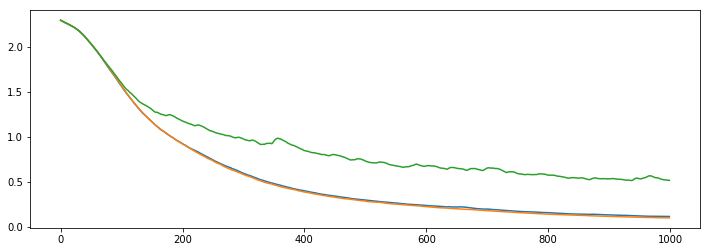

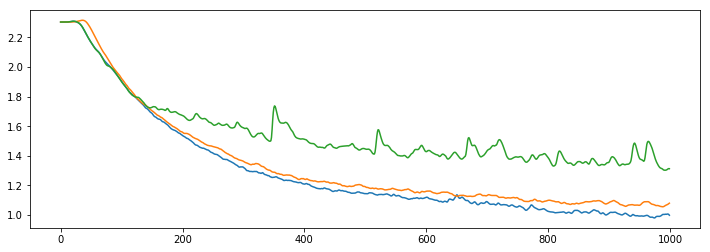

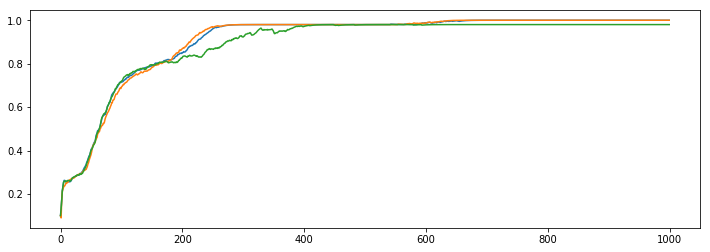

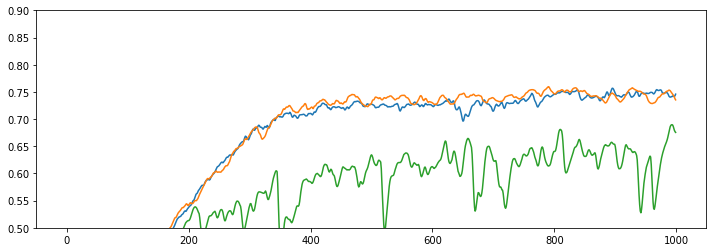

eta = 10

Epoch 1 of 1000 took 4.27s;
train loss:
data term: 2.30, constrain term: 0.00, full: 2.30
train acc: 10.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 9.58

Epoch 2 of 1000 took 4.15s;
train loss:
data term: 2.29, constrain term: 0.00, full: 2.29
train acc: 16.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 9.58

Epoch 3 of 1000 took 4.25s;
train loss:
data term: 2.29, constrain term: 0.00, full: 2.29
train acc: 24.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 9.58

Epoch 4 of 1000 took 4.50s;
train loss:
data term: 2.28, constrain term: 0.00, full: 2.28
train acc: 32.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 9.58

Epoch 5 of 1000 took 4.32s;
train loss:
data term: 2.27, constrain term: 0.00, full: 2.27
train acc: 30.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 9.58

Epoch 6 of 1000 took 4.22s;
train loss:
data term: 2.26, constrain term: 0.00, full: 2.26
train acc: 32.00
test loss:
data term: 2

Epoch 49 of 1000 took 4.56s;
train loss:
data term: 1.97, constrain term: 0.00, full: 1.97
train acc: 44.00
test loss:
data term: 2.12, constrain term: 0.00
test acc: 19.32

Epoch 50 of 1000 took 4.30s;
train loss:
data term: 1.96, constrain term: 0.00, full: 1.96
train acc: 52.00
test loss:
data term: 2.11, constrain term: 0.00
test acc: 19.63

Epoch 51 of 1000 took 4.26s;
train loss:
data term: 1.96, constrain term: 0.00, full: 1.96
train acc: 52.00
test loss:
data term: 2.11, constrain term: 0.00
test acc: 19.49

Epoch 52 of 1000 took 4.27s;
train loss:
data term: 1.95, constrain term: 0.00, full: 1.95
train acc: 46.00
test loss:
data term: 2.10, constrain term: 0.00
test acc: 19.59

Epoch 53 of 1000 took 4.80s;
train loss:
data term: 1.93, constrain term: 0.00, full: 1.93
train acc: 46.00
test loss:
data term: 2.10, constrain term: 0.00
test acc: 19.83

Epoch 54 of 1000 took 4.59s;
train loss:
data term: 1.94, constrain term: 0.00, full: 1.94
train acc: 50.00
test loss:
data term: 

Epoch 97 of 1000 took 4.60s;
train loss:
data term: 1.50, constrain term: 0.00, full: 1.51
train acc: 74.00
test loss:
data term: 1.87, constrain term: 0.00
test acc: 40.43

Epoch 98 of 1000 took 4.14s;
train loss:
data term: 1.49, constrain term: 0.00, full: 1.49
train acc: 76.00
test loss:
data term: 1.86, constrain term: 0.00
test acc: 42.17

Epoch 99 of 1000 took 4.47s;
train loss:
data term: 1.52, constrain term: 0.00, full: 1.52
train acc: 74.00
test loss:
data term: 1.85, constrain term: 0.00
test acc: 43.71

Epoch 100 of 1000 took 4.50s;
train loss:
data term: 1.49, constrain term: 0.00, full: 1.49
train acc: 74.00
test loss:
data term: 1.85, constrain term: 0.00
test acc: 44.24

Epoch 101 of 1000 took 4.29s;
train loss:
data term: 1.47, constrain term: 0.00, full: 1.47
train acc: 74.00
test loss:
data term: 1.84, constrain term: 0.00
test acc: 43.90

Epoch 102 of 1000 took 4.39s;
train loss:
data term: 1.47, constrain term: 0.00, full: 1.48
train acc: 72.00
test loss:
data ter

Epoch 144 of 1000 took 4.48s;
train loss:
data term: 1.18, constrain term: 0.00, full: 1.23
train acc: 78.00
test loss:
data term: 1.67, constrain term: 0.00
test acc: 46.41

Epoch 145 of 1000 took 4.09s;
train loss:
data term: 1.16, constrain term: 0.00, full: 1.17
train acc: 82.00
test loss:
data term: 1.67, constrain term: 0.00
test acc: 46.72

Epoch 146 of 1000 took 4.32s;
train loss:
data term: 1.16, constrain term: 0.00, full: 1.19
train acc: 78.00
test loss:
data term: 1.66, constrain term: 0.00
test acc: 47.19

Epoch 147 of 1000 took 4.09s;
train loss:
data term: 1.15, constrain term: 0.00, full: 1.16
train acc: 80.00
test loss:
data term: 1.65, constrain term: 0.00
test acc: 48.42

Epoch 148 of 1000 took 4.19s;
train loss:
data term: 1.14, constrain term: 0.00, full: 1.15
train acc: 80.00
test loss:
data term: 1.65, constrain term: 0.00
test acc: 49.90

Epoch 149 of 1000 took 4.24s;
train loss:
data term: 1.13, constrain term: 0.00, full: 1.13
train acc: 80.00
test loss:
data 

Epoch 191 of 1000 took 4.34s;
train loss:
data term: 0.96, constrain term: 0.01, full: 1.05
train acc: 84.00
test loss:
data term: 1.57, constrain term: 0.00
test acc: 51.98

Epoch 192 of 1000 took 4.20s;
train loss:
data term: 0.97, constrain term: 0.00, full: 0.99
train acc: 80.00
test loss:
data term: 1.56, constrain term: 0.00
test acc: 51.25

Epoch 193 of 1000 took 4.13s;
train loss:
data term: 0.98, constrain term: 0.00, full: 0.98
train acc: 84.00
test loss:
data term: 1.56, constrain term: 0.00
test acc: 51.15

Epoch 194 of 1000 took 4.05s;
train loss:
data term: 0.97, constrain term: 0.00, full: 0.98
train acc: 82.00
test loss:
data term: 1.56, constrain term: 0.00
test acc: 51.27

Epoch 195 of 1000 took 4.17s;
train loss:
data term: 0.97, constrain term: 0.00, full: 0.99
train acc: 86.00
test loss:
data term: 1.56, constrain term: 0.00
test acc: 51.66

Epoch 196 of 1000 took 4.22s;
train loss:
data term: 0.96, constrain term: 0.00, full: 0.96
train acc: 88.00
test loss:
data 

Epoch 238 of 1000 took 4.37s;
train loss:
data term: 0.83, constrain term: 0.00, full: 0.86
train acc: 94.00
test loss:
data term: 1.49, constrain term: 0.00
test acc: 56.71

Epoch 239 of 1000 took 4.45s;
train loss:
data term: 0.82, constrain term: 0.00, full: 0.85
train acc: 90.00
test loss:
data term: 1.48, constrain term: 0.00
test acc: 57.95

Epoch 240 of 1000 took 4.19s;
train loss:
data term: 0.81, constrain term: 0.00, full: 0.82
train acc: 90.00
test loss:
data term: 1.47, constrain term: 0.00
test acc: 59.24

Epoch 241 of 1000 took 4.38s;
train loss:
data term: 0.81, constrain term: 0.00, full: 0.82
train acc: 94.00
test loss:
data term: 1.46, constrain term: 0.00
test acc: 60.17

Epoch 242 of 1000 took 4.34s;
train loss:
data term: 0.81, constrain term: 0.00, full: 0.86
train acc: 94.00
test loss:
data term: 1.46, constrain term: 0.00
test acc: 60.30

Epoch 243 of 1000 took 4.27s;
train loss:
data term: 0.81, constrain term: 0.00, full: 0.85
train acc: 96.00
test loss:
data 

Epoch 285 of 1000 took 4.03s;
train loss:
data term: 0.69, constrain term: 0.00, full: 0.70
train acc: 98.00
test loss:
data term: 1.37, constrain term: 0.00
test acc: 63.44

Epoch 286 of 1000 took 4.02s;
train loss:
data term: 0.69, constrain term: 0.01, full: 0.75
train acc: 98.00
test loss:
data term: 1.36, constrain term: 0.00
test acc: 64.76

Epoch 287 of 1000 took 4.02s;
train loss:
data term: 0.70, constrain term: 0.01, full: 0.80
train acc: 98.00
test loss:
data term: 1.36, constrain term: 0.00
test acc: 64.06

Epoch 288 of 1000 took 4.02s;
train loss:
data term: 0.69, constrain term: 0.00, full: 0.69
train acc: 98.00
test loss:
data term: 1.38, constrain term: 0.00
test acc: 63.60

Epoch 289 of 1000 took 4.01s;
train loss:
data term: 0.70, constrain term: 0.00, full: 0.72
train acc: 98.00
test loss:
data term: 1.38, constrain term: 0.00
test acc: 63.48

Epoch 290 of 1000 took 4.01s;
train loss:
data term: 0.68, constrain term: 0.00, full: 0.69
train acc: 98.00
test loss:
data 

Epoch 332 of 1000 took 4.12s;
train loss:
data term: 0.58, constrain term: 0.00, full: 0.60
train acc: 98.00
test loss:
data term: 1.30, constrain term: 0.00
test acc: 67.51

Epoch 333 of 1000 took 4.02s;
train loss:
data term: 0.58, constrain term: 0.00, full: 0.63
train acc: 98.00
test loss:
data term: 1.29, constrain term: 0.00
test acc: 68.98

Epoch 334 of 1000 took 4.03s;
train loss:
data term: 0.58, constrain term: 0.01, full: 0.68
train acc: 98.00
test loss:
data term: 1.29, constrain term: 0.00
test acc: 67.22

Epoch 335 of 1000 took 3.99s;
train loss:
data term: 0.58, constrain term: 0.00, full: 0.59
train acc: 98.00
test loss:
data term: 1.30, constrain term: 0.00
test acc: 65.88

Epoch 336 of 1000 took 4.06s;
train loss:
data term: 0.57, constrain term: 0.00, full: 0.59
train acc: 98.00
test loss:
data term: 1.29, constrain term: 0.00
test acc: 68.21

Epoch 337 of 1000 took 4.05s;
train loss:
data term: 0.58, constrain term: 0.01, full: 0.64
train acc: 98.00
test loss:
data 

Epoch 379 of 1000 took 4.02s;
train loss:
data term: 0.51, constrain term: 0.00, full: 0.54
train acc: 98.00
test loss:
data term: 1.25, constrain term: 0.00
test acc: 67.81

Epoch 380 of 1000 took 4.05s;
train loss:
data term: 0.51, constrain term: 0.00, full: 0.54
train acc: 98.00
test loss:
data term: 1.25, constrain term: 0.00
test acc: 66.84

Epoch 381 of 1000 took 4.00s;
train loss:
data term: 0.51, constrain term: 0.00, full: 0.54
train acc: 98.00
test loss:
data term: 1.26, constrain term: 0.00
test acc: 65.90

Epoch 382 of 1000 took 3.99s;
train loss:
data term: 0.51, constrain term: 0.00, full: 0.53
train acc: 98.00
test loss:
data term: 1.25, constrain term: 0.00
test acc: 68.22

Epoch 383 of 1000 took 4.00s;
train loss:
data term: 0.50, constrain term: 0.00, full: 0.51
train acc: 98.00
test loss:
data term: 1.23, constrain term: 0.00
test acc: 70.59

Epoch 384 of 1000 took 4.00s;
train loss:
data term: 0.52, constrain term: 0.00, full: 0.52
train acc: 98.00
test loss:
data 

Epoch 426 of 1000 took 4.54s;
train loss:
data term: 0.46, constrain term: 0.00, full: 0.47
train acc: 98.00
test loss:
data term: 1.22, constrain term: 0.00
test acc: 71.21

Epoch 427 of 1000 took 4.11s;
train loss:
data term: 0.45, constrain term: 0.00, full: 0.49
train acc: 98.00
test loss:
data term: 1.19, constrain term: 0.00
test acc: 71.38

Epoch 428 of 1000 took 4.69s;
train loss:
data term: 0.44, constrain term: 0.01, full: 0.53
train acc: 98.00
test loss:
data term: 1.18, constrain term: 0.00
test acc: 71.15

Epoch 429 of 1000 took 4.61s;
train loss:
data term: 0.44, constrain term: 0.00, full: 0.47
train acc: 98.00
test loss:
data term: 1.17, constrain term: 0.00
test acc: 71.38

Epoch 430 of 1000 took 4.70s;
train loss:
data term: 0.45, constrain term: 0.00, full: 0.47
train acc: 98.00
test loss:
data term: 1.16, constrain term: 0.00
test acc: 72.31

Epoch 431 of 1000 took 4.88s;
train loss:
data term: 0.45, constrain term: 0.00, full: 0.47
train acc: 98.00
test loss:
data 

Epoch 473 of 1000 took 4.66s;
train loss:
data term: 0.39, constrain term: 0.00, full: 0.41
train acc: 98.00
test loss:
data term: 1.17, constrain term: 0.00
test acc: 75.08

Epoch 474 of 1000 took 4.79s;
train loss:
data term: 0.39, constrain term: 0.01, full: 0.49
train acc: 98.00
test loss:
data term: 1.16, constrain term: 0.00
test acc: 74.92

Epoch 475 of 1000 took 4.73s;
train loss:
data term: 0.38, constrain term: 0.00, full: 0.40
train acc: 98.00
test loss:
data term: 1.17, constrain term: 0.00
test acc: 73.53

Epoch 476 of 1000 took 4.55s;
train loss:
data term: 0.39, constrain term: 0.02, full: 0.54
train acc: 98.00
test loss:
data term: 1.20, constrain term: 0.00
test acc: 69.67

Epoch 477 of 1000 took 4.60s;
train loss:
data term: 0.40, constrain term: 0.00, full: 0.41
train acc: 98.00
test loss:
data term: 1.24, constrain term: 0.00
test acc: 66.41

Epoch 478 of 1000 took 4.23s;
train loss:
data term: 0.40, constrain term: 0.01, full: 0.50
train acc: 98.00
test loss:
data 

Epoch 520 of 1000 took 4.16s;
train loss:
data term: 0.38, constrain term: 0.01, full: 0.51
train acc: 98.00
test loss:
data term: 1.20, constrain term: 0.00
test acc: 72.19

Epoch 521 of 1000 took 4.06s;
train loss:
data term: 0.37, constrain term: 0.00, full: 0.41
train acc: 98.00
test loss:
data term: 1.15, constrain term: 0.00
test acc: 73.94

Epoch 522 of 1000 took 4.20s;
train loss:
data term: 0.37, constrain term: 0.00, full: 0.41
train acc: 98.00
test loss:
data term: 1.13, constrain term: 0.00
test acc: 73.22

Epoch 523 of 1000 took 4.11s;
train loss:
data term: 0.37, constrain term: 0.01, full: 0.44
train acc: 98.00
test loss:
data term: 1.13, constrain term: 0.00
test acc: 73.17

Epoch 524 of 1000 took 4.12s;
train loss:
data term: 0.37, constrain term: 0.00, full: 0.38
train acc: 98.00
test loss:
data term: 1.12, constrain term: 0.00
test acc: 74.18

Epoch 525 of 1000 took 4.01s;
train loss:
data term: 0.38, constrain term: 0.00, full: 0.41
train acc: 98.00
test loss:
data 

Epoch 567 of 1000 took 3.99s;
train loss:
data term: 0.32, constrain term: 0.00, full: 0.35
train acc: 98.00
test loss:
data term: 1.12, constrain term: 0.00
test acc: 74.33

Epoch 568 of 1000 took 4.00s;
train loss:
data term: 0.33, constrain term: 0.00, full: 0.36
train acc: 98.00
test loss:
data term: 1.11, constrain term: 0.00
test acc: 73.87

Epoch 569 of 1000 took 4.00s;
train loss:
data term: 0.33, constrain term: 0.00, full: 0.35
train acc: 98.00
test loss:
data term: 1.12, constrain term: 0.00
test acc: 73.66

Epoch 570 of 1000 took 4.02s;
train loss:
data term: 0.33, constrain term: 0.00, full: 0.37
train acc: 98.00
test loss:
data term: 1.13, constrain term: 0.00
test acc: 72.08

Epoch 571 of 1000 took 4.00s;
train loss:
data term: 0.32, constrain term: 0.02, full: 0.55
train acc: 98.00
test loss:
data term: 1.14, constrain term: 0.00
test acc: 69.48

Epoch 572 of 1000 took 4.01s;
train loss:
data term: 0.32, constrain term: 0.00, full: 0.36
train acc: 98.00
test loss:
data 

Epoch 614 of 1000 took 4.00s;
train loss:
data term: 0.33, constrain term: 0.00, full: 0.33
train acc: 98.00
test loss:
data term: 1.15, constrain term: 0.00
test acc: 69.15

Epoch 615 of 1000 took 4.01s;
train loss:
data term: 0.34, constrain term: 0.00, full: 0.36
train acc: 98.00
test loss:
data term: 1.13, constrain term: 0.00
test acc: 71.01

Epoch 616 of 1000 took 4.01s;
train loss:
data term: 0.33, constrain term: 0.00, full: 0.35
train acc: 98.00
test loss:
data term: 1.11, constrain term: 0.00
test acc: 73.35

Epoch 617 of 1000 took 4.01s;
train loss:
data term: 0.33, constrain term: 0.00, full: 0.36
train acc: 98.00
test loss:
data term: 1.10, constrain term: 0.00
test acc: 75.49

Epoch 618 of 1000 took 4.04s;
train loss:
data term: 0.33, constrain term: 0.00, full: 0.33
train acc: 98.00
test loss:
data term: 1.10, constrain term: 0.00
test acc: 76.63

Epoch 619 of 1000 took 4.01s;
train loss:
data term: 0.32, constrain term: 0.01, full: 0.41
train acc: 98.00
test loss:
data 

Epoch 661 of 1000 took 4.19s;
train loss:
data term: 0.30, constrain term: 0.00, full: 0.32
train acc: 98.00
test loss:
data term: 1.12, constrain term: 0.00
test acc: 72.02

Epoch 662 of 1000 took 4.16s;
train loss:
data term: 0.30, constrain term: 0.00, full: 0.34
train acc: 98.00
test loss:
data term: 1.12, constrain term: 0.00
test acc: 72.77

Epoch 663 of 1000 took 4.13s;
train loss:
data term: 0.29, constrain term: 0.00, full: 0.33
train acc: 98.00
test loss:
data term: 1.10, constrain term: 0.00
test acc: 73.19

Epoch 664 of 1000 took 4.22s;
train loss:
data term: 0.29, constrain term: 0.00, full: 0.29
train acc: 98.00
test loss:
data term: 1.10, constrain term: 0.00
test acc: 73.27

Epoch 665 of 1000 took 4.03s;
train loss:
data term: 0.30, constrain term: 0.01, full: 0.45
train acc: 98.00
test loss:
data term: 1.11, constrain term: 0.00
test acc: 73.21

Epoch 666 of 1000 took 4.03s;
train loss:
data term: 0.29, constrain term: 0.01, full: 0.41
train acc: 98.00
test loss:
data 

Epoch 708 of 1000 took 4.14s;
train loss:
data term: 0.28, constrain term: 0.00, full: 0.33
train acc: 98.00
test loss:
data term: 1.19, constrain term: 0.00
test acc: 66.33

Epoch 709 of 1000 took 4.00s;
train loss:
data term: 0.28, constrain term: 0.00, full: 0.31
train acc: 98.00
test loss:
data term: 1.19, constrain term: 0.00
test acc: 65.76

Epoch 710 of 1000 took 4.24s;
train loss:
data term: 0.29, constrain term: 0.00, full: 0.30
train acc: 98.00
test loss:
data term: 1.19, constrain term: 0.00
test acc: 66.60

Epoch 711 of 1000 took 4.00s;
train loss:
data term: 0.29, constrain term: 0.00, full: 0.33
train acc: 98.00
test loss:
data term: 1.15, constrain term: 0.00
test acc: 69.29

Epoch 712 of 1000 took 4.03s;
train loss:
data term: 0.29, constrain term: 0.01, full: 0.34
train acc: 98.00
test loss:
data term: 1.14, constrain term: 0.00
test acc: 71.29

Epoch 713 of 1000 took 4.01s;
train loss:
data term: 0.29, constrain term: 0.01, full: 0.34
train acc: 98.00
test loss:
data 

Epoch 755 of 1000 took 4.24s;
train loss:
data term: 0.25, constrain term: 0.00, full: 0.29
train acc: 98.00
test loss:
data term: 1.12, constrain term: 0.00
test acc: 72.00

Epoch 756 of 1000 took 4.57s;
train loss:
data term: 0.26, constrain term: 0.00, full: 0.27
train acc: 98.00
test loss:
data term: 1.11, constrain term: 0.00
test acc: 72.02

Epoch 757 of 1000 took 4.24s;
train loss:
data term: 0.26, constrain term: 0.00, full: 0.29
train acc: 98.00
test loss:
data term: 1.11, constrain term: 0.00
test acc: 72.31

Epoch 758 of 1000 took 4.42s;
train loss:
data term: 0.25, constrain term: 0.01, full: 0.35
train acc: 98.00
test loss:
data term: 1.12, constrain term: 0.00
test acc: 70.13

Epoch 759 of 1000 took 4.95s;
train loss:
data term: 0.25, constrain term: 0.01, full: 0.38
train acc: 98.00
test loss:
data term: 1.13, constrain term: 0.00
test acc: 68.95

Epoch 760 of 1000 took 4.78s;
train loss:
data term: 0.25, constrain term: 0.00, full: 0.30
train acc: 98.00
test loss:
data 

Epoch 802 of 1000 took 4.00s;
train loss:
data term: 0.25, constrain term: 0.01, full: 0.32
train acc: 98.00
test loss:
data term: 1.13, constrain term: 0.00
test acc: 70.42

Epoch 803 of 1000 took 4.01s;
train loss:
data term: 0.26, constrain term: 0.00, full: 0.26
train acc: 98.00
test loss:
data term: 1.11, constrain term: 0.00
test acc: 71.55

Epoch 804 of 1000 took 4.02s;
train loss:
data term: 0.26, constrain term: 0.01, full: 0.32
train acc: 100.00
test loss:
data term: 1.09, constrain term: 0.00
test acc: 73.68

Epoch 805 of 1000 took 4.02s;
train loss:
data term: 0.26, constrain term: 0.00, full: 0.30
train acc: 100.00
test loss:
data term: 1.06, constrain term: 0.00
test acc: 75.35

Epoch 806 of 1000 took 4.00s;
train loss:
data term: 0.25, constrain term: 0.01, full: 0.34
train acc: 98.00
test loss:
data term: 1.06, constrain term: 0.00
test acc: 75.86

Epoch 807 of 1000 took 4.01s;
train loss:
data term: 0.25, constrain term: 0.00, full: 0.29
train acc: 100.00
test loss:
da

Epoch 849 of 1000 took 4.58s;
train loss:
data term: 0.24, constrain term: 0.00, full: 0.28
train acc: 100.00
test loss:
data term: 1.12, constrain term: 0.00
test acc: 72.45

Epoch 850 of 1000 took 4.08s;
train loss:
data term: 0.24, constrain term: 0.01, full: 0.30
train acc: 100.00
test loss:
data term: 1.12, constrain term: 0.00
test acc: 72.63

Epoch 851 of 1000 took 4.49s;
train loss:
data term: 0.25, constrain term: 0.01, full: 0.31
train acc: 100.00
test loss:
data term: 1.09, constrain term: 0.00
test acc: 74.44

Epoch 852 of 1000 took 4.40s;
train loss:
data term: 0.25, constrain term: 0.01, full: 0.32
train acc: 98.00
test loss:
data term: 1.10, constrain term: 0.00
test acc: 74.39

Epoch 853 of 1000 took 4.67s;
train loss:
data term: 0.24, constrain term: 0.00, full: 0.27
train acc: 100.00
test loss:
data term: 1.08, constrain term: 0.00
test acc: 74.98

Epoch 854 of 1000 took 4.42s;
train loss:
data term: 0.25, constrain term: 0.00, full: 0.29
train acc: 100.00
test loss:


Epoch 896 of 1000 took 4.00s;
train loss:
data term: 0.22, constrain term: 0.01, full: 0.34
train acc: 100.00
test loss:
data term: 1.09, constrain term: 0.00
test acc: 74.75

Epoch 897 of 1000 took 4.08s;
train loss:
data term: 0.22, constrain term: 0.01, full: 0.33
train acc: 98.00
test loss:
data term: 1.08, constrain term: 0.00
test acc: 74.21

Epoch 898 of 1000 took 4.01s;
train loss:
data term: 0.22, constrain term: 0.00, full: 0.25
train acc: 100.00
test loss:
data term: 1.07, constrain term: 0.00
test acc: 74.04

Epoch 899 of 1000 took 4.04s;
train loss:
data term: 0.24, constrain term: 0.00, full: 0.26
train acc: 100.00
test loss:
data term: 1.06, constrain term: 0.00
test acc: 73.05

Epoch 900 of 1000 took 4.00s;
train loss:
data term: 0.24, constrain term: 0.00, full: 0.26
train acc: 100.00
test loss:
data term: 1.05, constrain term: 0.00
test acc: 73.62

Epoch 901 of 1000 took 4.04s;
train loss:
data term: 0.23, constrain term: 0.01, full: 0.34
train acc: 100.00
test loss:


Epoch 943 of 1000 took 4.01s;
train loss:
data term: 0.23, constrain term: 0.00, full: 0.26
train acc: 100.00
test loss:
data term: 1.14, constrain term: 0.00
test acc: 68.12

Epoch 944 of 1000 took 4.01s;
train loss:
data term: 0.24, constrain term: 0.01, full: 0.30
train acc: 98.00
test loss:
data term: 1.10, constrain term: 0.00
test acc: 70.21

Epoch 945 of 1000 took 4.08s;
train loss:
data term: 0.22, constrain term: 0.00, full: 0.23
train acc: 100.00
test loss:
data term: 1.07, constrain term: 0.00
test acc: 73.18

Epoch 946 of 1000 took 4.04s;
train loss:
data term: 0.23, constrain term: 0.01, full: 0.28
train acc: 100.00
test loss:
data term: 1.04, constrain term: 0.00
test acc: 74.52

Epoch 947 of 1000 took 4.02s;
train loss:
data term: 0.22, constrain term: 0.00, full: 0.25
train acc: 100.00
test loss:
data term: 1.02, constrain term: 0.00
test acc: 75.31

Epoch 948 of 1000 took 4.06s;
train loss:
data term: 0.22, constrain term: 0.01, full: 0.28
train acc: 100.00
test loss:


Epoch 990 of 1000 took 4.00s;
train loss:
data term: 0.21, constrain term: 0.01, full: 0.31
train acc: 100.00
test loss:
data term: 0.99, constrain term: 0.00
test acc: 76.76

Epoch 991 of 1000 took 4.04s;
train loss:
data term: 0.22, constrain term: 0.01, full: 0.29
train acc: 100.00
test loss:
data term: 0.99, constrain term: 0.00
test acc: 76.44

Epoch 992 of 1000 took 4.01s;
train loss:
data term: 0.23, constrain term: 0.00, full: 0.24
train acc: 100.00
test loss:
data term: 1.00, constrain term: 0.00
test acc: 76.31

Epoch 993 of 1000 took 4.00s;
train loss:
data term: 0.21, constrain term: 0.00, full: 0.25
train acc: 100.00
test loss:
data term: 1.00, constrain term: 0.00
test acc: 76.18

Epoch 994 of 1000 took 4.25s;
train loss:
data term: 0.21, constrain term: 0.00, full: 0.24
train acc: 100.00
test loss:
data term: 1.00, constrain term: 0.00
test acc: 75.84

Epoch 995 of 1000 took 4.18s;
train loss:
data term: 0.21, constrain term: 0.00, full: 0.25
train acc: 100.00
test loss:

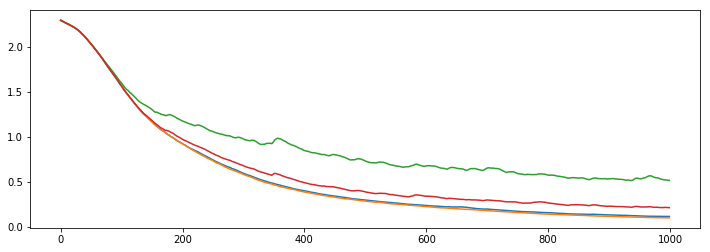

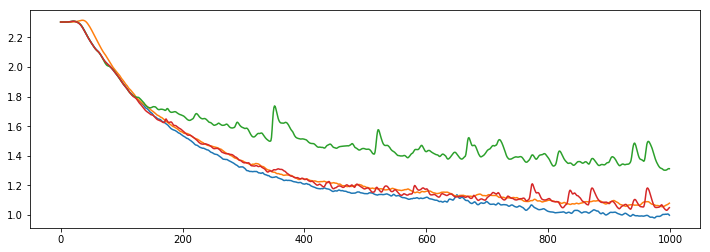

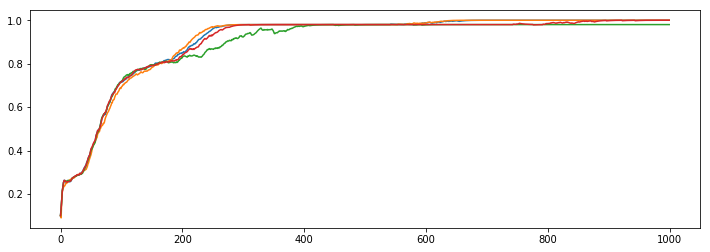

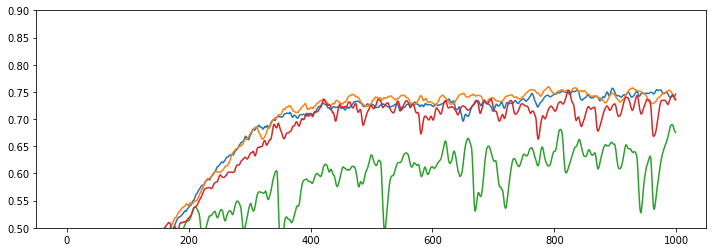

run 2
eta = 1

Epoch 1 of 1000 took 4.14s;
train loss:
data term: 2.33, constrain term: 0.00, full: 2.33
train acc: 10.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 2 of 1000 took 3.98s;
train loss:
data term: 2.33, constrain term: 0.00, full: 2.33
train acc: 6.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 3 of 1000 took 4.00s;
train loss:
data term: 2.32, constrain term: 0.00, full: 2.32
train acc: 14.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 4 of 1000 took 4.07s;
train loss:
data term: 2.31, constrain term: 0.00, full: 2.31
train acc: 12.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 5 of 1000 took 3.99s;
train loss:
data term: 2.30, constrain term: 0.00, full: 2.30
train acc: 16.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 6 of 1000 took 4.01s;
train loss:
data term: 2.30, constrain term: 0.00, full: 2.30
train acc: 18.00
test loss:
dat

Epoch 49 of 1000 took 4.00s;
train loss:
data term: 2.00, constrain term: 0.00, full: 2.00
train acc: 44.00
test loss:
data term: 2.15, constrain term: 0.00
test acc: 28.30

Epoch 50 of 1000 took 4.00s;
train loss:
data term: 1.99, constrain term: 0.00, full: 1.99
train acc: 48.00
test loss:
data term: 2.15, constrain term: 0.00
test acc: 28.54

Epoch 51 of 1000 took 4.00s;
train loss:
data term: 2.00, constrain term: 0.00, full: 2.00
train acc: 42.00
test loss:
data term: 2.15, constrain term: 0.00
test acc: 29.00

Epoch 52 of 1000 took 3.99s;
train loss:
data term: 1.98, constrain term: 0.00, full: 1.98
train acc: 46.00
test loss:
data term: 2.14, constrain term: 0.00
test acc: 29.38

Epoch 53 of 1000 took 3.99s;
train loss:
data term: 1.98, constrain term: 0.00, full: 1.98
train acc: 40.00
test loss:
data term: 2.14, constrain term: 0.00
test acc: 29.68

Epoch 54 of 1000 took 4.00s;
train loss:
data term: 1.96, constrain term: 0.00, full: 1.96
train acc: 44.00
test loss:
data term: 

Epoch 97 of 1000 took 4.23s;
train loss:
data term: 1.57, constrain term: 0.00, full: 1.57
train acc: 66.00
test loss:
data term: 1.96, constrain term: 0.00
test acc: 40.89

Epoch 98 of 1000 took 4.06s;
train loss:
data term: 1.55, constrain term: 0.00, full: 1.55
train acc: 68.00
test loss:
data term: 1.96, constrain term: 0.00
test acc: 40.27

Epoch 99 of 1000 took 4.01s;
train loss:
data term: 1.58, constrain term: 0.00, full: 1.58
train acc: 70.00
test loss:
data term: 1.96, constrain term: 0.00
test acc: 39.81

Epoch 100 of 1000 took 4.00s;
train loss:
data term: 1.56, constrain term: 0.00, full: 1.56
train acc: 74.00
test loss:
data term: 1.96, constrain term: 0.00
test acc: 39.37

Epoch 101 of 1000 took 3.99s;
train loss:
data term: 1.57, constrain term: 0.00, full: 1.57
train acc: 66.00
test loss:
data term: 1.94, constrain term: 0.00
test acc: 39.37

Epoch 102 of 1000 took 4.04s;
train loss:
data term: 1.53, constrain term: 0.00, full: 1.53
train acc: 74.00
test loss:
data ter

Epoch 144 of 1000 took 4.00s;
train loss:
data term: 1.25, constrain term: 0.00, full: 1.25
train acc: 84.00
test loss:
data term: 1.75, constrain term: 0.00
test acc: 47.82

Epoch 145 of 1000 took 4.02s;
train loss:
data term: 1.21, constrain term: 0.00, full: 1.21
train acc: 84.00
test loss:
data term: 1.75, constrain term: 0.00
test acc: 48.25

Epoch 146 of 1000 took 4.05s;
train loss:
data term: 1.21, constrain term: 0.00, full: 1.22
train acc: 84.00
test loss:
data term: 1.75, constrain term: 0.00
test acc: 48.97

Epoch 147 of 1000 took 4.00s;
train loss:
data term: 1.19, constrain term: 0.00, full: 1.19
train acc: 86.00
test loss:
data term: 1.75, constrain term: 0.00
test acc: 49.56

Epoch 148 of 1000 took 4.00s;
train loss:
data term: 1.22, constrain term: 0.01, full: 1.22
train acc: 82.00
test loss:
data term: 1.74, constrain term: 0.00
test acc: 49.42

Epoch 149 of 1000 took 3.99s;
train loss:
data term: 1.18, constrain term: 0.00, full: 1.18
train acc: 86.00
test loss:
data 

Epoch 191 of 1000 took 4.00s;
train loss:
data term: 0.98, constrain term: 0.00, full: 0.98
train acc: 86.00
test loss:
data term: 1.62, constrain term: 0.00
test acc: 54.05

Epoch 192 of 1000 took 4.00s;
train loss:
data term: 0.95, constrain term: 0.00, full: 0.96
train acc: 86.00
test loss:
data term: 1.62, constrain term: 0.00
test acc: 54.31

Epoch 193 of 1000 took 4.02s;
train loss:
data term: 0.96, constrain term: 0.00, full: 0.96
train acc: 86.00
test loss:
data term: 1.60, constrain term: 0.00
test acc: 54.61

Epoch 194 of 1000 took 4.00s;
train loss:
data term: 0.96, constrain term: 0.00, full: 0.96
train acc: 86.00
test loss:
data term: 1.59, constrain term: 0.00
test acc: 54.35

Epoch 195 of 1000 took 4.01s;
train loss:
data term: 0.95, constrain term: 0.00, full: 0.95
train acc: 88.00
test loss:
data term: 1.59, constrain term: 0.00
test acc: 54.03

Epoch 196 of 1000 took 4.00s;
train loss:
data term: 0.96, constrain term: 0.00, full: 0.96
train acc: 86.00
test loss:
data 

Epoch 238 of 1000 took 4.00s;
train loss:
data term: 0.77, constrain term: 0.00, full: 0.77
train acc: 94.00
test loss:
data term: 1.44, constrain term: 0.00
test acc: 60.58

Epoch 239 of 1000 took 4.00s;
train loss:
data term: 0.77, constrain term: 0.00, full: 0.78
train acc: 90.00
test loss:
data term: 1.46, constrain term: 0.00
test acc: 59.99

Epoch 240 of 1000 took 4.00s;
train loss:
data term: 0.76, constrain term: 0.01, full: 0.77
train acc: 88.00
test loss:
data term: 1.48, constrain term: 0.00
test acc: 58.29

Epoch 241 of 1000 took 4.01s;
train loss:
data term: 0.77, constrain term: 0.00, full: 0.77
train acc: 90.00
test loss:
data term: 1.48, constrain term: 0.00
test acc: 57.67

Epoch 242 of 1000 took 4.01s;
train loss:
data term: 0.75, constrain term: 0.00, full: 0.75
train acc: 92.00
test loss:
data term: 1.47, constrain term: 0.00
test acc: 58.17

Epoch 243 of 1000 took 3.99s;
train loss:
data term: 0.76, constrain term: 0.00, full: 0.76
train acc: 92.00
test loss:
data 

Epoch 285 of 1000 took 3.99s;
train loss:
data term: 0.63, constrain term: 0.01, full: 0.64
train acc: 94.00
test loss:
data term: 1.40, constrain term: 0.00
test acc: 61.42

Epoch 286 of 1000 took 4.00s;
train loss:
data term: 0.63, constrain term: 0.01, full: 0.64
train acc: 96.00
test loss:
data term: 1.40, constrain term: 0.00
test acc: 61.22

Epoch 287 of 1000 took 4.00s;
train loss:
data term: 0.61, constrain term: 0.00, full: 0.62
train acc: 96.00
test loss:
data term: 1.40, constrain term: 0.00
test acc: 61.54

Epoch 288 of 1000 took 4.01s;
train loss:
data term: 0.62, constrain term: 0.00, full: 0.63
train acc: 94.00
test loss:
data term: 1.40, constrain term: 0.00
test acc: 61.65

Epoch 289 of 1000 took 4.00s;
train loss:
data term: 0.63, constrain term: 0.01, full: 0.64
train acc: 94.00
test loss:
data term: 1.39, constrain term: 0.00
test acc: 62.28

Epoch 290 of 1000 took 4.01s;
train loss:
data term: 0.61, constrain term: 0.01, full: 0.62
train acc: 98.00
test loss:
data 

Epoch 332 of 1000 took 4.01s;
train loss:
data term: 0.51, constrain term: 0.01, full: 0.52
train acc: 100.00
test loss:
data term: 1.32, constrain term: 0.00
test acc: 66.61

Epoch 333 of 1000 took 4.00s;
train loss:
data term: 0.50, constrain term: 0.00, full: 0.50
train acc: 98.00
test loss:
data term: 1.31, constrain term: 0.00
test acc: 67.13

Epoch 334 of 1000 took 4.01s;
train loss:
data term: 0.50, constrain term: 0.00, full: 0.51
train acc: 100.00
test loss:
data term: 1.29, constrain term: 0.00
test acc: 68.74

Epoch 335 of 1000 took 4.02s;
train loss:
data term: 0.51, constrain term: 0.01, full: 0.52
train acc: 100.00
test loss:
data term: 1.28, constrain term: 0.00
test acc: 68.78

Epoch 336 of 1000 took 4.02s;
train loss:
data term: 0.51, constrain term: 0.01, full: 0.51
train acc: 98.00
test loss:
data term: 1.27, constrain term: 0.00
test acc: 68.64

Epoch 337 of 1000 took 4.00s;
train loss:
data term: 0.51, constrain term: 0.01, full: 0.51
train acc: 100.00
test loss:
d

Epoch 379 of 1000 took 3.99s;
train loss:
data term: 0.42, constrain term: 0.01, full: 0.42
train acc: 100.00
test loss:
data term: 1.23, constrain term: 0.00
test acc: 72.88

Epoch 380 of 1000 took 4.11s;
train loss:
data term: 0.43, constrain term: 0.02, full: 0.44
train acc: 100.00
test loss:
data term: 1.24, constrain term: 0.00
test acc: 72.25

Epoch 381 of 1000 took 3.99s;
train loss:
data term: 0.41, constrain term: 0.01, full: 0.42
train acc: 100.00
test loss:
data term: 1.24, constrain term: 0.00
test acc: 72.76

Epoch 382 of 1000 took 3.99s;
train loss:
data term: 0.41, constrain term: 0.00, full: 0.41
train acc: 100.00
test loss:
data term: 1.24, constrain term: 0.00
test acc: 72.49

Epoch 383 of 1000 took 4.01s;
train loss:
data term: 0.41, constrain term: 0.01, full: 0.42
train acc: 100.00
test loss:
data term: 1.24, constrain term: 0.00
test acc: 71.24

Epoch 384 of 1000 took 4.02s;
train loss:
data term: 0.42, constrain term: 0.00, full: 0.42
train acc: 100.00
test loss:

Epoch 426 of 1000 took 4.01s;
train loss:
data term: 0.34, constrain term: 0.01, full: 0.35
train acc: 100.00
test loss:
data term: 1.19, constrain term: 0.00
test acc: 73.30

Epoch 427 of 1000 took 3.99s;
train loss:
data term: 0.34, constrain term: 0.00, full: 0.34
train acc: 100.00
test loss:
data term: 1.18, constrain term: 0.00
test acc: 73.87

Epoch 428 of 1000 took 3.99s;
train loss:
data term: 0.34, constrain term: 0.01, full: 0.35
train acc: 100.00
test loss:
data term: 1.18, constrain term: 0.00
test acc: 74.23

Epoch 429 of 1000 took 4.00s;
train loss:
data term: 0.33, constrain term: 0.01, full: 0.34
train acc: 100.00
test loss:
data term: 1.19, constrain term: 0.00
test acc: 74.25

Epoch 430 of 1000 took 4.00s;
train loss:
data term: 0.34, constrain term: 0.01, full: 0.35
train acc: 100.00
test loss:
data term: 1.19, constrain term: 0.00
test acc: 73.34

Epoch 431 of 1000 took 3.99s;
train loss:
data term: 0.34, constrain term: 0.01, full: 0.34
train acc: 100.00
test loss:

Epoch 473 of 1000 took 4.00s;
train loss:
data term: 0.29, constrain term: 0.01, full: 0.30
train acc: 100.00
test loss:
data term: 1.15, constrain term: 0.00
test acc: 73.10

Epoch 474 of 1000 took 4.03s;
train loss:
data term: 0.29, constrain term: 0.01, full: 0.30
train acc: 100.00
test loss:
data term: 1.16, constrain term: 0.00
test acc: 73.27

Epoch 475 of 1000 took 4.00s;
train loss:
data term: 0.30, constrain term: 0.01, full: 0.31
train acc: 100.00
test loss:
data term: 1.15, constrain term: 0.00
test acc: 73.41

Epoch 476 of 1000 took 4.00s;
train loss:
data term: 0.29, constrain term: 0.01, full: 0.29
train acc: 100.00
test loss:
data term: 1.15, constrain term: 0.00
test acc: 73.08

Epoch 477 of 1000 took 4.00s;
train loss:
data term: 0.29, constrain term: 0.01, full: 0.29
train acc: 100.00
test loss:
data term: 1.16, constrain term: 0.00
test acc: 72.56

Epoch 478 of 1000 took 3.99s;
train loss:
data term: 0.28, constrain term: 0.02, full: 0.30
train acc: 100.00
test loss:

Epoch 520 of 1000 took 3.99s;
train loss:
data term: 0.25, constrain term: 0.01, full: 0.26
train acc: 100.00
test loss:
data term: 1.12, constrain term: 0.00
test acc: 73.15

Epoch 521 of 1000 took 4.00s;
train loss:
data term: 0.25, constrain term: 0.01, full: 0.25
train acc: 100.00
test loss:
data term: 1.13, constrain term: 0.00
test acc: 73.08

Epoch 522 of 1000 took 4.00s;
train loss:
data term: 0.24, constrain term: 0.01, full: 0.25
train acc: 100.00
test loss:
data term: 1.14, constrain term: 0.00
test acc: 72.83

Epoch 523 of 1000 took 4.05s;
train loss:
data term: 0.25, constrain term: 0.02, full: 0.27
train acc: 100.00
test loss:
data term: 1.14, constrain term: 0.00
test acc: 72.86

Epoch 524 of 1000 took 3.99s;
train loss:
data term: 0.24, constrain term: 0.01, full: 0.24
train acc: 100.00
test loss:
data term: 1.13, constrain term: 0.00
test acc: 73.73

Epoch 525 of 1000 took 4.00s;
train loss:
data term: 0.24, constrain term: 0.01, full: 0.25
train acc: 100.00
test loss:

Epoch 567 of 1000 took 4.02s;
train loss:
data term: 0.22, constrain term: 0.01, full: 0.23
train acc: 100.00
test loss:
data term: 1.09, constrain term: 0.00
test acc: 74.34

Epoch 568 of 1000 took 4.01s;
train loss:
data term: 0.21, constrain term: 0.01, full: 0.22
train acc: 100.00
test loss:
data term: 1.09, constrain term: 0.00
test acc: 74.54

Epoch 569 of 1000 took 4.03s;
train loss:
data term: 0.22, constrain term: 0.01, full: 0.23
train acc: 100.00
test loss:
data term: 1.10, constrain term: 0.00
test acc: 74.38

Epoch 570 of 1000 took 4.04s;
train loss:
data term: 0.22, constrain term: 0.01, full: 0.23
train acc: 100.00
test loss:
data term: 1.11, constrain term: 0.00
test acc: 72.49

Epoch 571 of 1000 took 4.03s;
train loss:
data term: 0.21, constrain term: 0.01, full: 0.22
train acc: 100.00
test loss:
data term: 1.11, constrain term: 0.00
test acc: 72.41

Epoch 572 of 1000 took 4.04s;
train loss:
data term: 0.22, constrain term: 0.02, full: 0.24
train acc: 100.00
test loss:

Epoch 614 of 1000 took 4.00s;
train loss:
data term: 0.20, constrain term: 0.01, full: 0.20
train acc: 100.00
test loss:
data term: 1.08, constrain term: 0.00
test acc: 74.03

Epoch 615 of 1000 took 4.01s;
train loss:
data term: 0.19, constrain term: 0.01, full: 0.20
train acc: 100.00
test loss:
data term: 1.08, constrain term: 0.00
test acc: 74.29

Epoch 616 of 1000 took 4.01s;
train loss:
data term: 0.19, constrain term: 0.02, full: 0.21
train acc: 100.00
test loss:
data term: 1.07, constrain term: 0.00
test acc: 75.05

Epoch 617 of 1000 took 4.01s;
train loss:
data term: 0.19, constrain term: 0.01, full: 0.20
train acc: 100.00
test loss:
data term: 1.07, constrain term: 0.00
test acc: 74.92

Epoch 618 of 1000 took 3.99s;
train loss:
data term: 0.19, constrain term: 0.01, full: 0.21
train acc: 100.00
test loss:
data term: 1.08, constrain term: 0.00
test acc: 74.59

Epoch 619 of 1000 took 4.00s;
train loss:
data term: 0.19, constrain term: 0.01, full: 0.20
train acc: 100.00
test loss:

Epoch 661 of 1000 took 4.03s;
train loss:
data term: 0.17, constrain term: 0.01, full: 0.18
train acc: 100.00
test loss:
data term: 1.05, constrain term: 0.00
test acc: 74.53

Epoch 662 of 1000 took 4.00s;
train loss:
data term: 0.17, constrain term: 0.01, full: 0.18
train acc: 100.00
test loss:
data term: 1.04, constrain term: 0.00
test acc: 74.57

Epoch 663 of 1000 took 4.06s;
train loss:
data term: 0.17, constrain term: 0.01, full: 0.19
train acc: 100.00
test loss:
data term: 1.04, constrain term: 0.00
test acc: 74.88

Epoch 664 of 1000 took 4.01s;
train loss:
data term: 0.18, constrain term: 0.01, full: 0.19
train acc: 100.00
test loss:
data term: 1.05, constrain term: 0.00
test acc: 75.15

Epoch 665 of 1000 took 4.03s;
train loss:
data term: 0.17, constrain term: 0.01, full: 0.18
train acc: 100.00
test loss:
data term: 1.06, constrain term: 0.00
test acc: 73.89

Epoch 666 of 1000 took 4.02s;
train loss:
data term: 0.17, constrain term: 0.01, full: 0.18
train acc: 100.00
test loss:

Epoch 708 of 1000 took 4.01s;
train loss:
data term: 0.15, constrain term: 0.01, full: 0.16
train acc: 100.00
test loss:
data term: 1.04, constrain term: 0.00
test acc: 75.85

Epoch 709 of 1000 took 3.99s;
train loss:
data term: 0.15, constrain term: 0.01, full: 0.17
train acc: 100.00
test loss:
data term: 1.03, constrain term: 0.00
test acc: 75.23

Epoch 710 of 1000 took 3.99s;
train loss:
data term: 0.15, constrain term: 0.02, full: 0.17
train acc: 100.00
test loss:
data term: 1.03, constrain term: 0.00
test acc: 75.32

Epoch 711 of 1000 took 4.00s;
train loss:
data term: 0.15, constrain term: 0.01, full: 0.16
train acc: 100.00
test loss:
data term: 1.04, constrain term: 0.00
test acc: 74.64

Epoch 712 of 1000 took 4.02s;
train loss:
data term: 0.15, constrain term: 0.02, full: 0.17
train acc: 100.00
test loss:
data term: 1.05, constrain term: 0.00
test acc: 73.58

Epoch 713 of 1000 took 4.03s;
train loss:
data term: 0.15, constrain term: 0.01, full: 0.16
train acc: 100.00
test loss:

Epoch 755 of 1000 took 3.99s;
train loss:
data term: 0.14, constrain term: 0.02, full: 0.16
train acc: 100.00
test loss:
data term: 1.02, constrain term: 0.00
test acc: 74.93

Epoch 756 of 1000 took 4.00s;
train loss:
data term: 0.15, constrain term: 0.01, full: 0.15
train acc: 100.00
test loss:
data term: 1.02, constrain term: 0.00
test acc: 74.17

Epoch 757 of 1000 took 4.00s;
train loss:
data term: 0.14, constrain term: 0.01, full: 0.16
train acc: 100.00
test loss:
data term: 1.03, constrain term: 0.00
test acc: 74.21

Epoch 758 of 1000 took 4.02s;
train loss:
data term: 0.15, constrain term: 0.02, full: 0.17
train acc: 100.00
test loss:
data term: 1.03, constrain term: 0.00
test acc: 74.70

Epoch 759 of 1000 took 4.00s;
train loss:
data term: 0.14, constrain term: 0.01, full: 0.15
train acc: 100.00
test loss:
data term: 1.01, constrain term: 0.00
test acc: 75.41

Epoch 760 of 1000 took 4.01s;
train loss:
data term: 0.15, constrain term: 0.01, full: 0.15
train acc: 100.00
test loss:

Epoch 802 of 1000 took 4.01s;
train loss:
data term: 0.13, constrain term: 0.02, full: 0.15
train acc: 100.00
test loss:
data term: 1.01, constrain term: 0.00
test acc: 75.65

Epoch 803 of 1000 took 4.03s;
train loss:
data term: 0.13, constrain term: 0.01, full: 0.14
train acc: 100.00
test loss:
data term: 1.02, constrain term: 0.00
test acc: 75.91

Epoch 804 of 1000 took 4.03s;
train loss:
data term: 0.13, constrain term: 0.02, full: 0.15
train acc: 100.00
test loss:
data term: 1.01, constrain term: 0.00
test acc: 76.10

Epoch 805 of 1000 took 4.00s;
train loss:
data term: 0.13, constrain term: 0.01, full: 0.14
train acc: 100.00
test loss:
data term: 1.02, constrain term: 0.00
test acc: 75.53

Epoch 806 of 1000 took 4.00s;
train loss:
data term: 0.13, constrain term: 0.02, full: 0.15
train acc: 100.00
test loss:
data term: 1.03, constrain term: 0.00
test acc: 74.28

Epoch 807 of 1000 took 4.02s;
train loss:
data term: 0.13, constrain term: 0.02, full: 0.15
train acc: 100.00
test loss:

Epoch 849 of 1000 took 4.00s;
train loss:
data term: 0.12, constrain term: 0.01, full: 0.13
train acc: 100.00
test loss:
data term: 1.00, constrain term: 0.00
test acc: 75.06

Epoch 850 of 1000 took 4.00s;
train loss:
data term: 0.12, constrain term: 0.01, full: 0.14
train acc: 100.00
test loss:
data term: 1.00, constrain term: 0.00
test acc: 74.67

Epoch 851 of 1000 took 4.07s;
train loss:
data term: 0.12, constrain term: 0.01, full: 0.13
train acc: 100.00
test loss:
data term: 1.00, constrain term: 0.00
test acc: 74.84

Epoch 852 of 1000 took 4.02s;
train loss:
data term: 0.12, constrain term: 0.01, full: 0.14
train acc: 100.00
test loss:
data term: 1.00, constrain term: 0.00
test acc: 74.89

Epoch 853 of 1000 took 3.99s;
train loss:
data term: 0.12, constrain term: 0.01, full: 0.13
train acc: 100.00
test loss:
data term: 0.99, constrain term: 0.00
test acc: 75.63

Epoch 854 of 1000 took 4.04s;
train loss:
data term: 0.12, constrain term: 0.01, full: 0.13
train acc: 100.00
test loss:

Epoch 896 of 1000 took 4.00s;
train loss:
data term: 0.11, constrain term: 0.01, full: 0.12
train acc: 100.00
test loss:
data term: 1.00, constrain term: 0.00
test acc: 74.60

Epoch 897 of 1000 took 3.99s;
train loss:
data term: 0.11, constrain term: 0.01, full: 0.12
train acc: 100.00
test loss:
data term: 0.98, constrain term: 0.00
test acc: 75.99

Epoch 898 of 1000 took 4.00s;
train loss:
data term: 0.11, constrain term: 0.02, full: 0.13
train acc: 100.00
test loss:
data term: 0.98, constrain term: 0.00
test acc: 76.18

Epoch 899 of 1000 took 4.00s;
train loss:
data term: 0.11, constrain term: 0.01, full: 0.12
train acc: 100.00
test loss:
data term: 0.98, constrain term: 0.00
test acc: 76.12

Epoch 900 of 1000 took 4.00s;
train loss:
data term: 0.11, constrain term: 0.02, full: 0.13
train acc: 100.00
test loss:
data term: 0.97, constrain term: 0.00
test acc: 76.68

Epoch 901 of 1000 took 4.01s;
train loss:
data term: 0.11, constrain term: 0.01, full: 0.12
train acc: 100.00
test loss:

Epoch 943 of 1000 took 4.02s;
train loss:
data term: 0.10, constrain term: 0.03, full: 0.13
train acc: 100.00
test loss:
data term: 0.94, constrain term: 0.00
test acc: 77.05

Epoch 944 of 1000 took 4.00s;
train loss:
data term: 0.11, constrain term: 0.01, full: 0.12
train acc: 100.00
test loss:
data term: 0.93, constrain term: 0.00
test acc: 76.84

Epoch 945 of 1000 took 3.99s;
train loss:
data term: 0.11, constrain term: 0.01, full: 0.12
train acc: 100.00
test loss:
data term: 0.94, constrain term: 0.00
test acc: 76.93

Epoch 946 of 1000 took 3.99s;
train loss:
data term: 0.11, constrain term: 0.01, full: 0.12
train acc: 100.00
test loss:
data term: 0.94, constrain term: 0.00
test acc: 77.08

Epoch 947 of 1000 took 4.03s;
train loss:
data term: 0.11, constrain term: 0.01, full: 0.12
train acc: 100.00
test loss:
data term: 0.95, constrain term: 0.00
test acc: 77.05

Epoch 948 of 1000 took 4.00s;
train loss:
data term: 0.11, constrain term: 0.01, full: 0.12
train acc: 100.00
test loss:

Epoch 990 of 1000 took 3.99s;
train loss:
data term: 0.10, constrain term: 0.01, full: 0.11
train acc: 100.00
test loss:
data term: 0.98, constrain term: 0.00
test acc: 74.79

Epoch 991 of 1000 took 4.02s;
train loss:
data term: 0.10, constrain term: 0.01, full: 0.11
train acc: 100.00
test loss:
data term: 0.99, constrain term: 0.00
test acc: 74.54

Epoch 992 of 1000 took 4.00s;
train loss:
data term: 0.10, constrain term: 0.01, full: 0.11
train acc: 100.00
test loss:
data term: 1.00, constrain term: 0.00
test acc: 74.79

Epoch 993 of 1000 took 4.01s;
train loss:
data term: 0.10, constrain term: 0.01, full: 0.11
train acc: 100.00
test loss:
data term: 0.99, constrain term: 0.00
test acc: 74.44

Epoch 994 of 1000 took 4.00s;
train loss:
data term: 0.10, constrain term: 0.01, full: 0.11
train acc: 100.00
test loss:
data term: 0.98, constrain term: 0.00
test acc: 74.77

Epoch 995 of 1000 took 4.00s;
train loss:
data term: 0.10, constrain term: 0.01, full: 0.11
train acc: 100.00
test loss:

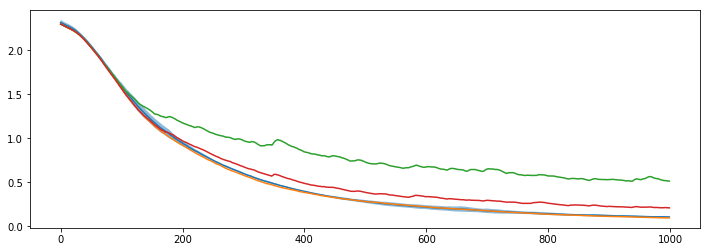

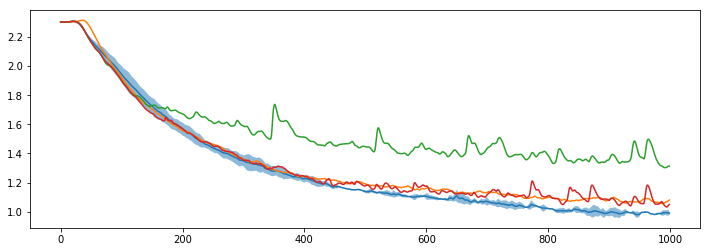

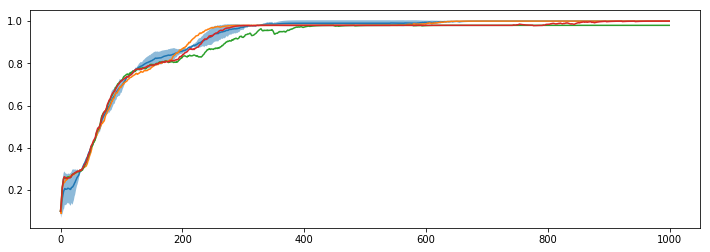

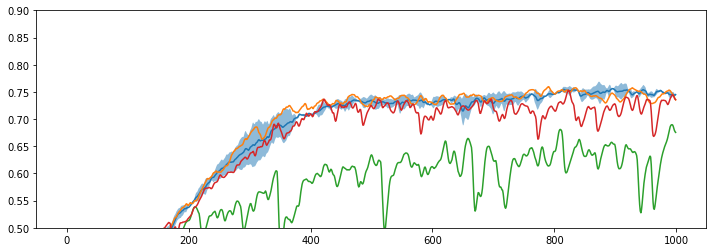

eta = 0

Epoch 1 of 1000 took 3.60s;
train loss:
data term: 2.33, constrain term: 0.00, full: 2.33
train acc: 10.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 2 of 1000 took 3.45s;
train loss:
data term: 2.33, constrain term: 0.00, full: 2.33
train acc: 16.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 3 of 1000 took 3.32s;
train loss:
data term: 2.32, constrain term: 0.00, full: 2.32
train acc: 12.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 4 of 1000 took 3.39s;
train loss:
data term: 2.31, constrain term: 0.00, full: 2.31
train acc: 18.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 5 of 1000 took 3.20s;
train loss:
data term: 2.31, constrain term: 0.00, full: 2.31
train acc: 8.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 6 of 1000 took 3.19s;
train loss:
data term: 2.30, constrain term: 0.00, full: 2.30
train acc: 14.00
test loss:
data term

Epoch 49 of 1000 took 3.16s;
train loss:
data term: 2.00, constrain term: 0.00, full: 2.00
train acc: 50.00
test loss:
data term: 2.25, constrain term: 0.00
test acc: 19.41

Epoch 50 of 1000 took 3.17s;
train loss:
data term: 2.00, constrain term: 0.00, full: 2.00
train acc: 42.00
test loss:
data term: 2.24, constrain term: 0.00
test acc: 20.64

Epoch 51 of 1000 took 3.16s;
train loss:
data term: 1.99, constrain term: 0.00, full: 1.99
train acc: 46.00
test loss:
data term: 2.23, constrain term: 0.00
test acc: 21.67

Epoch 52 of 1000 took 3.17s;
train loss:
data term: 1.96, constrain term: 0.00, full: 1.96
train acc: 44.00
test loss:
data term: 2.23, constrain term: 0.00
test acc: 22.42

Epoch 53 of 1000 took 3.18s;
train loss:
data term: 1.95, constrain term: 0.00, full: 1.95
train acc: 50.00
test loss:
data term: 2.22, constrain term: 0.00
test acc: 22.90

Epoch 54 of 1000 took 3.17s;
train loss:
data term: 1.97, constrain term: 0.00, full: 1.97
train acc: 46.00
test loss:
data term: 

Epoch 97 of 1000 took 3.16s;
train loss:
data term: 1.57, constrain term: 0.00, full: 1.57
train acc: 72.00
test loss:
data term: 2.04, constrain term: 0.00
test acc: 25.96

Epoch 98 of 1000 took 3.16s;
train loss:
data term: 1.56, constrain term: 0.00, full: 1.56
train acc: 74.00
test loss:
data term: 2.02, constrain term: 0.00
test acc: 29.29

Epoch 99 of 1000 took 3.18s;
train loss:
data term: 1.56, constrain term: 0.00, full: 1.56
train acc: 70.00
test loss:
data term: 2.01, constrain term: 0.00
test acc: 31.08

Epoch 100 of 1000 took 3.17s;
train loss:
data term: 1.55, constrain term: 0.00, full: 1.55
train acc: 72.00
test loss:
data term: 1.99, constrain term: 0.00
test acc: 31.97

Epoch 101 of 1000 took 3.17s;
train loss:
data term: 1.55, constrain term: 0.00, full: 1.55
train acc: 70.00
test loss:
data term: 1.99, constrain term: 0.00
test acc: 32.62

Epoch 102 of 1000 took 3.17s;
train loss:
data term: 1.54, constrain term: 0.00, full: 1.54
train acc: 70.00
test loss:
data ter

Epoch 144 of 1000 took 3.17s;
train loss:
data term: 1.23, constrain term: 0.00, full: 1.23
train acc: 80.00
test loss:
data term: 1.81, constrain term: 0.00
test acc: 47.18

Epoch 145 of 1000 took 3.17s;
train loss:
data term: 1.24, constrain term: 0.00, full: 1.24
train acc: 82.00
test loss:
data term: 1.82, constrain term: 0.00
test acc: 46.32

Epoch 146 of 1000 took 3.42s;
train loss:
data term: 1.21, constrain term: 0.00, full: 1.21
train acc: 82.00
test loss:
data term: 1.81, constrain term: 0.00
test acc: 47.61

Epoch 147 of 1000 took 3.37s;
train loss:
data term: 1.22, constrain term: 0.00, full: 1.22
train acc: 80.00
test loss:
data term: 1.81, constrain term: 0.00
test acc: 47.95

Epoch 148 of 1000 took 3.24s;
train loss:
data term: 1.24, constrain term: 0.00, full: 1.24
train acc: 80.00
test loss:
data term: 1.81, constrain term: 0.00
test acc: 48.05

Epoch 149 of 1000 took 3.22s;
train loss:
data term: 1.21, constrain term: 0.00, full: 1.21
train acc: 84.00
test loss:
data 

Epoch 191 of 1000 took 3.19s;
train loss:
data term: 0.98, constrain term: 0.00, full: 0.98
train acc: 86.00
test loss:
data term: 1.68, constrain term: 0.00
test acc: 51.22

Epoch 192 of 1000 took 3.18s;
train loss:
data term: 0.97, constrain term: 0.00, full: 0.97
train acc: 86.00
test loss:
data term: 1.69, constrain term: 0.00
test acc: 52.10

Epoch 193 of 1000 took 3.18s;
train loss:
data term: 0.97, constrain term: 0.00, full: 0.97
train acc: 86.00
test loss:
data term: 1.67, constrain term: 0.00
test acc: 52.90

Epoch 194 of 1000 took 3.17s;
train loss:
data term: 0.98, constrain term: 0.00, full: 0.98
train acc: 86.00
test loss:
data term: 1.66, constrain term: 0.00
test acc: 52.67

Epoch 195 of 1000 took 3.18s;
train loss:
data term: 0.98, constrain term: 0.00, full: 0.98
train acc: 86.00
test loss:
data term: 1.66, constrain term: 0.00
test acc: 52.70

Epoch 196 of 1000 took 3.16s;
train loss:
data term: 0.96, constrain term: 0.00, full: 0.96
train acc: 86.00
test loss:
data 

Epoch 238 of 1000 took 3.36s;
train loss:
data term: 0.77, constrain term: 0.00, full: 0.77
train acc: 88.00
test loss:
data term: 1.53, constrain term: 0.00
test acc: 59.32

Epoch 239 of 1000 took 3.33s;
train loss:
data term: 0.78, constrain term: 0.00, full: 0.78
train acc: 92.00
test loss:
data term: 1.53, constrain term: 0.00
test acc: 58.98

Epoch 240 of 1000 took 3.18s;
train loss:
data term: 0.78, constrain term: 0.00, full: 0.78
train acc: 90.00
test loss:
data term: 1.52, constrain term: 0.00
test acc: 58.63

Epoch 241 of 1000 took 3.17s;
train loss:
data term: 0.77, constrain term: 0.00, full: 0.77
train acc: 92.00
test loss:
data term: 1.53, constrain term: 0.00
test acc: 58.65

Epoch 242 of 1000 took 3.18s;
train loss:
data term: 0.80, constrain term: 0.00, full: 0.80
train acc: 90.00
test loss:
data term: 1.52, constrain term: 0.00
test acc: 59.59

Epoch 243 of 1000 took 3.18s;
train loss:
data term: 0.76, constrain term: 0.00, full: 0.76
train acc: 88.00
test loss:
data 

Epoch 285 of 1000 took 3.17s;
train loss:
data term: 0.61, constrain term: 0.00, full: 0.61
train acc: 94.00
test loss:
data term: 1.46, constrain term: 0.00
test acc: 60.73

Epoch 286 of 1000 took 3.19s;
train loss:
data term: 0.63, constrain term: 0.00, full: 0.63
train acc: 94.00
test loss:
data term: 1.47, constrain term: 0.00
test acc: 60.55

Epoch 287 of 1000 took 3.17s;
train loss:
data term: 0.63, constrain term: 0.00, full: 0.63
train acc: 96.00
test loss:
data term: 1.46, constrain term: 0.00
test acc: 60.53

Epoch 288 of 1000 took 3.18s;
train loss:
data term: 0.64, constrain term: 0.00, full: 0.64
train acc: 94.00
test loss:
data term: 1.45, constrain term: 0.00
test acc: 61.33

Epoch 289 of 1000 took 3.17s;
train loss:
data term: 0.61, constrain term: 0.00, full: 0.61
train acc: 98.00
test loss:
data term: 1.44, constrain term: 0.00
test acc: 61.39

Epoch 290 of 1000 took 3.18s;
train loss:
data term: 0.62, constrain term: 0.00, full: 0.62
train acc: 96.00
test loss:
data 

Epoch 332 of 1000 took 3.18s;
train loss:
data term: 0.51, constrain term: 0.00, full: 0.51
train acc: 98.00
test loss:
data term: 1.42, constrain term: 0.00
test acc: 64.28

Epoch 333 of 1000 took 3.15s;
train loss:
data term: 0.52, constrain term: 0.00, full: 0.52
train acc: 100.00
test loss:
data term: 1.41, constrain term: 0.00
test acc: 65.34

Epoch 334 of 1000 took 3.17s;
train loss:
data term: 0.50, constrain term: 0.00, full: 0.50
train acc: 100.00
test loss:
data term: 1.39, constrain term: 0.00
test acc: 66.03

Epoch 335 of 1000 took 3.18s;
train loss:
data term: 0.52, constrain term: 0.00, full: 0.52
train acc: 98.00
test loss:
data term: 1.39, constrain term: 0.00
test acc: 65.74

Epoch 336 of 1000 took 3.18s;
train loss:
data term: 0.50, constrain term: 0.00, full: 0.50
train acc: 100.00
test loss:
data term: 1.39, constrain term: 0.00
test acc: 64.61

Epoch 337 of 1000 took 3.17s;
train loss:
data term: 0.51, constrain term: 0.00, full: 0.51
train acc: 98.00
test loss:
da

Epoch 379 of 1000 took 3.16s;
train loss:
data term: 0.42, constrain term: 0.00, full: 0.42
train acc: 100.00
test loss:
data term: 1.33, constrain term: 0.00
test acc: 69.02

Epoch 380 of 1000 took 3.17s;
train loss:
data term: 0.42, constrain term: 0.00, full: 0.42
train acc: 100.00
test loss:
data term: 1.33, constrain term: 0.00
test acc: 69.17

Epoch 381 of 1000 took 3.17s;
train loss:
data term: 0.42, constrain term: 0.00, full: 0.42
train acc: 100.00
test loss:
data term: 1.32, constrain term: 0.00
test acc: 69.63

Epoch 382 of 1000 took 3.17s;
train loss:
data term: 0.43, constrain term: 0.00, full: 0.43
train acc: 100.00
test loss:
data term: 1.32, constrain term: 0.00
test acc: 69.80

Epoch 383 of 1000 took 3.18s;
train loss:
data term: 0.41, constrain term: 0.00, full: 0.41
train acc: 100.00
test loss:
data term: 1.33, constrain term: 0.00
test acc: 68.94

Epoch 384 of 1000 took 3.17s;
train loss:
data term: 0.43, constrain term: 0.00, full: 0.43
train acc: 100.00
test loss:

Epoch 426 of 1000 took 3.19s;
train loss:
data term: 0.35, constrain term: 0.00, full: 0.35
train acc: 100.00
test loss:
data term: 1.30, constrain term: 0.00
test acc: 70.99

Epoch 427 of 1000 took 3.20s;
train loss:
data term: 0.36, constrain term: 0.00, full: 0.36
train acc: 100.00
test loss:
data term: 1.30, constrain term: 0.00
test acc: 71.32

Epoch 428 of 1000 took 3.17s;
train loss:
data term: 0.34, constrain term: 0.00, full: 0.34
train acc: 100.00
test loss:
data term: 1.29, constrain term: 0.00
test acc: 72.38

Epoch 429 of 1000 took 3.21s;
train loss:
data term: 0.34, constrain term: 0.00, full: 0.34
train acc: 100.00
test loss:
data term: 1.30, constrain term: 0.00
test acc: 72.05

Epoch 430 of 1000 took 3.18s;
train loss:
data term: 0.34, constrain term: 0.00, full: 0.34
train acc: 100.00
test loss:
data term: 1.30, constrain term: 0.00
test acc: 71.36

Epoch 431 of 1000 took 3.19s;
train loss:
data term: 0.35, constrain term: 0.00, full: 0.35
train acc: 100.00
test loss:

Epoch 473 of 1000 took 3.17s;
train loss:
data term: 0.28, constrain term: 0.00, full: 0.28
train acc: 100.00
test loss:
data term: 1.27, constrain term: 0.00
test acc: 71.27

Epoch 474 of 1000 took 3.18s;
train loss:
data term: 0.29, constrain term: 0.00, full: 0.29
train acc: 100.00
test loss:
data term: 1.27, constrain term: 0.00
test acc: 71.69

Epoch 475 of 1000 took 3.18s;
train loss:
data term: 0.28, constrain term: 0.00, full: 0.28
train acc: 100.00
test loss:
data term: 1.27, constrain term: 0.00
test acc: 71.70

Epoch 476 of 1000 took 3.18s;
train loss:
data term: 0.28, constrain term: 0.00, full: 0.28
train acc: 100.00
test loss:
data term: 1.27, constrain term: 0.00
test acc: 72.15

Epoch 477 of 1000 took 3.20s;
train loss:
data term: 0.28, constrain term: 0.00, full: 0.28
train acc: 100.00
test loss:
data term: 1.27, constrain term: 0.00
test acc: 72.46

Epoch 478 of 1000 took 3.17s;
train loss:
data term: 0.28, constrain term: 0.00, full: 0.28
train acc: 100.00
test loss:

Epoch 520 of 1000 took 3.17s;
train loss:
data term: 0.24, constrain term: 0.00, full: 0.24
train acc: 100.00
test loss:
data term: 1.24, constrain term: 0.00
test acc: 72.79

Epoch 521 of 1000 took 3.18s;
train loss:
data term: 0.24, constrain term: 0.00, full: 0.24
train acc: 100.00
test loss:
data term: 1.23, constrain term: 0.00
test acc: 73.04

Epoch 522 of 1000 took 3.17s;
train loss:
data term: 0.25, constrain term: 0.00, full: 0.25
train acc: 100.00
test loss:
data term: 1.22, constrain term: 0.00
test acc: 73.09

Epoch 523 of 1000 took 3.19s;
train loss:
data term: 0.25, constrain term: 0.00, full: 0.25
train acc: 100.00
test loss:
data term: 1.23, constrain term: 0.00
test acc: 72.59

Epoch 524 of 1000 took 3.16s;
train loss:
data term: 0.24, constrain term: 0.00, full: 0.24
train acc: 100.00
test loss:
data term: 1.24, constrain term: 0.00
test acc: 72.25

Epoch 525 of 1000 took 3.17s;
train loss:
data term: 0.24, constrain term: 0.00, full: 0.24
train acc: 100.00
test loss:

Epoch 567 of 1000 took 3.18s;
train loss:
data term: 0.21, constrain term: 0.00, full: 0.21
train acc: 100.00
test loss:
data term: 1.22, constrain term: 0.00
test acc: 73.03

Epoch 568 of 1000 took 3.17s;
train loss:
data term: 0.21, constrain term: 0.00, full: 0.21
train acc: 100.00
test loss:
data term: 1.22, constrain term: 0.00
test acc: 72.96

Epoch 569 of 1000 took 3.17s;
train loss:
data term: 0.21, constrain term: 0.00, full: 0.21
train acc: 100.00
test loss:
data term: 1.22, constrain term: 0.00
test acc: 72.24

Epoch 570 of 1000 took 3.18s;
train loss:
data term: 0.20, constrain term: 0.00, full: 0.20
train acc: 100.00
test loss:
data term: 1.22, constrain term: 0.00
test acc: 72.12

Epoch 571 of 1000 took 3.17s;
train loss:
data term: 0.21, constrain term: 0.00, full: 0.21
train acc: 100.00
test loss:
data term: 1.22, constrain term: 0.00
test acc: 71.96

Epoch 572 of 1000 took 3.18s;
train loss:
data term: 0.20, constrain term: 0.00, full: 0.20
train acc: 100.00
test loss:

Epoch 614 of 1000 took 3.19s;
train loss:
data term: 0.19, constrain term: 0.00, full: 0.19
train acc: 100.00
test loss:
data term: 1.20, constrain term: 0.00
test acc: 72.43

Epoch 615 of 1000 took 3.18s;
train loss:
data term: 0.18, constrain term: 0.00, full: 0.18
train acc: 100.00
test loss:
data term: 1.21, constrain term: 0.00
test acc: 72.16

Epoch 616 of 1000 took 3.18s;
train loss:
data term: 0.18, constrain term: 0.00, full: 0.18
train acc: 100.00
test loss:
data term: 1.23, constrain term: 0.00
test acc: 71.33

Epoch 617 of 1000 took 3.19s;
train loss:
data term: 0.18, constrain term: 0.00, full: 0.18
train acc: 100.00
test loss:
data term: 1.23, constrain term: 0.00
test acc: 71.53

Epoch 618 of 1000 took 3.18s;
train loss:
data term: 0.18, constrain term: 0.00, full: 0.18
train acc: 100.00
test loss:
data term: 1.22, constrain term: 0.00
test acc: 71.73

Epoch 619 of 1000 took 3.22s;
train loss:
data term: 0.19, constrain term: 0.00, full: 0.19
train acc: 100.00
test loss:

Epoch 661 of 1000 took 3.18s;
train loss:
data term: 0.17, constrain term: 0.00, full: 0.17
train acc: 100.00
test loss:
data term: 1.21, constrain term: 0.00
test acc: 71.45

Epoch 662 of 1000 took 3.20s;
train loss:
data term: 0.16, constrain term: 0.00, full: 0.16
train acc: 100.00
test loss:
data term: 1.21, constrain term: 0.00
test acc: 71.46

Epoch 663 of 1000 took 3.19s;
train loss:
data term: 0.16, constrain term: 0.00, full: 0.16
train acc: 100.00
test loss:
data term: 1.21, constrain term: 0.00
test acc: 71.34

Epoch 664 of 1000 took 3.18s;
train loss:
data term: 0.16, constrain term: 0.00, full: 0.16
train acc: 100.00
test loss:
data term: 1.20, constrain term: 0.00
test acc: 71.78

Epoch 665 of 1000 took 3.19s;
train loss:
data term: 0.17, constrain term: 0.00, full: 0.17
train acc: 100.00
test loss:
data term: 1.19, constrain term: 0.00
test acc: 72.42

Epoch 666 of 1000 took 3.19s;
train loss:
data term: 0.16, constrain term: 0.00, full: 0.16
train acc: 100.00
test loss:

Epoch 708 of 1000 took 3.20s;
train loss:
data term: 0.14, constrain term: 0.00, full: 0.14
train acc: 100.00
test loss:
data term: 1.22, constrain term: 0.00
test acc: 69.54

Epoch 709 of 1000 took 3.22s;
train loss:
data term: 0.14, constrain term: 0.00, full: 0.14
train acc: 100.00
test loss:
data term: 1.23, constrain term: 0.00
test acc: 68.60

Epoch 710 of 1000 took 3.21s;
train loss:
data term: 0.15, constrain term: 0.00, full: 0.15
train acc: 100.00
test loss:
data term: 1.23, constrain term: 0.00
test acc: 69.13

Epoch 711 of 1000 took 3.21s;
train loss:
data term: 0.14, constrain term: 0.00, full: 0.14
train acc: 100.00
test loss:
data term: 1.21, constrain term: 0.00
test acc: 69.99

Epoch 712 of 1000 took 3.23s;
train loss:
data term: 0.15, constrain term: 0.00, full: 0.15
train acc: 100.00
test loss:
data term: 1.20, constrain term: 0.00
test acc: 70.94

Epoch 713 of 1000 took 3.20s;
train loss:
data term: 0.14, constrain term: 0.00, full: 0.14
train acc: 100.00
test loss:

Epoch 755 of 1000 took 3.19s;
train loss:
data term: 0.13, constrain term: 0.00, full: 0.13
train acc: 100.00
test loss:
data term: 1.20, constrain term: 0.00
test acc: 69.62

Epoch 756 of 1000 took 3.20s;
train loss:
data term: 0.13, constrain term: 0.00, full: 0.13
train acc: 100.00
test loss:
data term: 1.20, constrain term: 0.00
test acc: 69.66

Epoch 757 of 1000 took 3.19s;
train loss:
data term: 0.13, constrain term: 0.00, full: 0.13
train acc: 100.00
test loss:
data term: 1.20, constrain term: 0.00
test acc: 70.27

Epoch 758 of 1000 took 3.20s;
train loss:
data term: 0.13, constrain term: 0.00, full: 0.13
train acc: 100.00
test loss:
data term: 1.19, constrain term: 0.00
test acc: 70.88

Epoch 759 of 1000 took 3.21s;
train loss:
data term: 0.13, constrain term: 0.00, full: 0.13
train acc: 100.00
test loss:
data term: 1.19, constrain term: 0.00
test acc: 70.95

Epoch 760 of 1000 took 3.19s;
train loss:
data term: 0.13, constrain term: 0.00, full: 0.13
train acc: 100.00
test loss:

In [ ]:
num_epochs = 1000
num_runs = 5
save_every = 10000

etas = [1, 0, 100, 10]
for eta in etas[2:]:
    train_losses[eta] = []
    train_accs[eta] = []
    
    test_losses[eta] = []
    test_accs[eta] = []

loss_function = nn.CrossEntropyLoss()

for run in range(num_runs):
    print('run', run+1)

    for j, eta in list(enumerate(etas))[(2 if run==0 else 0):]:
        print('eta =', eta)
        print()

        train_losses[eta].append([])
        train_accs[eta].append([])

        test_losses[eta].append([])
        test_accs[eta].append([])

        torch.manual_seed(run)
        torch.cuda.manual_seed(run)
        np.random.seed(run)

        model = ModelConvolutional(input_shape, output_size).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))
        #scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda k: ((num_epochs-k)/200 if k >= num_epochs-200 else 1))
    
        train_dataset_labelled, train_dataset_unlabelled, train_labels_labelled, train_labels_unlabelled = train_test_split(
            padded_train_data, np.array(train_loader.dataset.train_labels), train_size=50
        )
        
        train_loader_labelled = DataLoader(
            TensorDataset(
                torch.from_numpy(train_dataset_labelled).float() / 255, 
                torch.Tensor(train_labels_labelled).long()
            ),
            batch_size=batch_size, shuffle=True, **kwargs
        )
        train_loader_unlabelled = DataLoader(
            TensorDataset(
                torch.from_numpy(train_dataset_unlabelled).float() / 255, 
                torch.Tensor(train_labels_unlabelled).long()
            ),
            batch_size=batch_size, shuffle=True, **kwargs
        )
        
        for epoch in range(num_epochs):
            start_time = time()
    
            #scheduler.step()
    
            cum_loss_data = 0
            cum_loss_constrain = 0
            cum_loss_full = 0
            cum_acc = 0
            batch_count = 0

            model.train()
            train_iter_unlabelled = iter(train_loader_unlabelled)
            for X, y in train_loader_labelled:
                X, y = X.to(device), y.to(device)
                prediction = model(X)
                loss_data = loss_function(prediction, y)
                cum_loss_data += loss_data.item()
                
                if eta < 1e-15:
                    loss_constrain = torch.tensor(0., device=device)
                else:
                    loss_constrain = constrain_loss_function(
                        model, dae, batch_gen=train_iter_unlabelled, reparam_invariant=True, use_all_classes=False
                    )
                cum_loss_constrain += loss_constrain.item()
        
                loss_full = loss_data + eta * loss_constrain
                cum_loss_full += loss_full.item()
            
                acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
                cum_acc += acc.item()
        
                optimizer.zero_grad()
                loss_full.backward()
                optimizer.step()
                batch_count += 1
            
            mean_train_loss_data = cum_loss_data / batch_count
            mean_train_loss_constrain = cum_loss_constrain / batch_count
            mean_train_loss_full = cum_loss_full / batch_count
            mean_train_acc = cum_acc / batch_count

            train_losses[eta][-1].append(mean_train_loss_data)
            train_accs[eta][-1].append(mean_train_acc)
        
            cum_loss_data = 0
            cum_loss_constrain = 0
            cum_acc = 0
            batch_count = 0

            model.eval()
            with torch.no_grad():
                for X, y in test_loader:
                    X, y = X.to(device), y.to(device)
                    prediction = model(X)
                    loss_data = loss_function(prediction, y)
                    cum_loss_data += loss_data.item()
        
                    acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
                    cum_acc += acc.item()
        
                    batch_count += 1
            
            mean_test_loss_data = cum_loss_data / batch_count
            mean_test_loss_constrain = cum_loss_constrain / batch_count
            mean_test_acc = cum_acc / batch_count

            test_losses[eta][-1].append(mean_test_loss_data)
            test_accs[eta][-1].append(mean_test_acc)
        
            print('Epoch {} of {} took {:.2f}s;'.format(epoch+1, num_epochs, time() - start_time))
            print('train loss:')
            print(
                'data term: {:.2f}, constrain term: {:.2f}, full: {:.2f}'.format(
                    mean_train_loss_data, mean_train_loss_constrain, mean_train_loss_full
                )
            )
            print('train acc: {:.2f}'.format(mean_train_acc*100))
            print('test loss:')
            print(
                'data term: {:.2f}, constrain term: {:.2f}'.format(
                    mean_test_loss_data, mean_test_loss_constrain
                )
            )
            print('test acc: {:.2f}'.format(mean_test_acc*100))
            print()
        
            if (epoch+1) % save_every == 0:
                with open(name_prefix + mode_name + '/train_losses.pkl', 'wb') as f:
                    pickle.dump(np.array(train_losses[mode]), f)
                with open(name_prefix + mode_name + '/test_losses.pkl', 'wb') as f:
                    pickle.dump(np.array(test_losses[mode]), f)
                with open(name_prefix + mode_name + '/train_accs.pkl', 'wb') as f:
                    pickle.dump(np.array(train_accs[mode]), f)
                with open(name_prefix + mode_name + '/test_accs.pkl', 'wb') as f:
                    pickle.dump(np.array(test_accs[mode]), f)

                torch.save(model.state_dict(), name_prefix + mode_name + '/model.pt')

            if (epoch+1) % num_epochs == 0:
                alpha=0.1
                fig = plt.figure(figsize=(12, 4))
                for i in range(j+1 if run==0 else len(etas)):
                    curve = DataFrame(train_losses[etas[i]]).ewm(alpha=alpha, axis=1).mean()
                    plt.plot(curve.mean(axis=0))
                    plt.fill_between(
                        np.arange(curve.shape[1]),
                        curve.mean(axis=0) - curve.std(axis=0),
                        curve.mean(axis=0) + curve.std(axis=0),
                        alpha=0.5
                    )
                plt.show()
                fig = plt.figure(figsize=(12, 4))
                for i in range(j+1 if run==0 else len(etas)):
                    curve = DataFrame(test_losses[etas[i]]).ewm(alpha=alpha, axis=1).mean()
                    plt.plot(curve.mean(axis=0))
                    plt.fill_between(
                        np.arange(curve.shape[1]),
                        curve.mean(axis=0) - curve.std(axis=0),
                        curve.mean(axis=0) + curve.std(axis=0),
                        alpha=0.5
                    )
                plt.show()
                fig = plt.figure(figsize=(12, 4))
                for i in range(j+1 if run==0 else len(etas)):
                    curve = DataFrame(train_accs[etas[i]]).ewm(alpha=alpha, axis=1).mean()
                    plt.plot(curve.mean(axis=0))
                    plt.fill_between(
                        np.arange(curve.shape[1]),
                        curve.mean(axis=0) - curve.std(axis=0),
                        curve.mean(axis=0) + curve.std(axis=0),
                        alpha=0.5
                    )
                plt.show()
                fig = plt.figure(figsize=(12, 4))
                for i in range(j+1 if run==0 else len(etas)):
                    curve = DataFrame(test_accs[etas[i]]).ewm(alpha=alpha, axis=1).mean()
                    plt.plot(curve.mean(axis=0))
                    plt.fill_between(
                        np.arange(curve.shape[1]),
                        curve.mean(axis=0) - curve.std(axis=0),
                        curve.mean(axis=0) + curve.std(axis=0),
                        alpha=0.5
                    )
                plt.ylim(0.5, 0.9)
                plt.show()
            
#train_losses[mode] = np.array(train_losses[mode])
#test_losses[mode] = np.array(test_losses[mode])
#train_accs[mode] = np.array(train_accs[mode])
#test_accs[mode] = np.array(test_accs[mode])
    

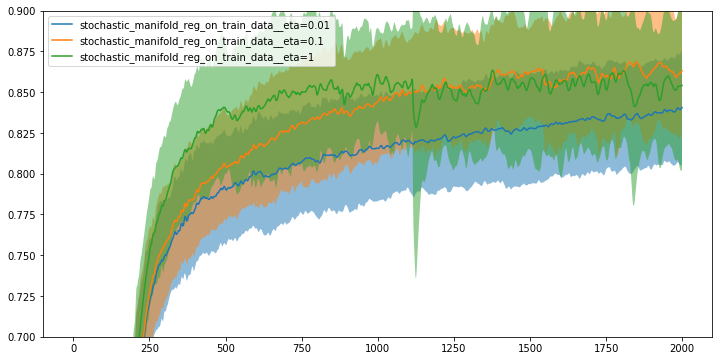

In [34]:
plt.figure(figsize=(12, 6))

alpha = 0.1
for mode in modes:
    curve = DataFrame(test_accs[mode]).ewm(alpha=alpha, axis=1).mean()
    plt.plot(curve.mean(axis=0))
    plt.fill_between(
        range(num_epochs),
        curve.mean(axis=0) - curve.std(axis=0),
        curve.mean(axis=0) + curve.std(axis=0),
        alpha=0.5
    )
plt.ylim(0.7, 0.9)
plt.legend(modes)

In [35]:
for mode in modes:
    print('{}: {:.2f} +- {:.2f}'.format(
        mode, 
        DataFrame(test_accs[mode]).ewm(alpha=alpha, axis=1).mean().mean(axis=0).max() * 100, 
        DataFrame(test_accs[mode]).ewm(alpha=alpha, axis=1).mean().std(axis=0)[
            np.argmax(DataFrame(test_accs[mode]).ewm(alpha=alpha, axis=1).mean().mean(axis=0))
        ] * 100, 
    ))

stochastic_manifold_reg_on_train_data__eta=0.01: 84.06 +- 3.48
stochastic_manifold_reg_on_train_data__eta=0.1: 86.87 +- 3.70
stochastic_manifold_reg_on_train_data__eta=1: 86.35 +- 3.62
